# Feature Engineering

In this notebook I will create many versions of the cleaned data by implementing several strategies for applying scalers, resampling techniques, outlier removal techniques, and PCA.

## Objectives
* Create a new column indicating if the row was a duplcate
* One hot encode the "Time column"
* Perform Train/Test split
* Perform Scaling
* Perform Resampling
* Remove outliers
* Check for multicolinearity
* PCA

## Tools used
* Numpy
* Pandas
* Matplotlib
* Seaborn
* Sklearn
* Scipy
* Imblearn
* Pickle

#### Load Data

I will begin by importing the necessary libraries.

In [63]:
# Import Libraries
import numpy as np # arrays
import math
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import zscore, iqr # zscore and interquartile range
from imblearn.over_sampling import SMOTE # SMOTE
from imblearn.under_sampling import NearMiss # Near Miss
from sklearn.decomposition import PCA # Principal component analysis
import time # Record time
import pickle

Now I will load the cleaned data into a pandas dataframe. I will also split the data into independent variables (X) and the dependent variable (y).

In [64]:
# Load data
pickle_in = open("clean_data.pickle", "rb")
df = pickle.load(pickle_in)
pickle_in.close()

# Seperate X and y
X = df.drop('Class', axis=1)
y = df.Class

# Sanity check
print(df.shape)
df.head(3)

(284807, 31)


Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69      0  
2 -0.327642 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]

Now I will go ahead and save this cleaned data for later use. I will save it in a file called "cleaned_data.pickle" located in the folder called "Modeling" which is located in this directory. I will do this using pickle. Pickle is a tool to save python objects in a binary file.

# Numpy: One hot encode the Time Column
I will cut the time column by the hour and set it to the appopriate time of day (i.e. hour 25 will be set to equal hour 1 because it is the first hour in the second day), then get the dummy features for it. I convert Time to the "int8" datatype so as to not run into memory errors with my machine.

In [65]:
# create bins by the hour
bins = range(0, 3600 * 48 + 1, 3600)

# cut the Time column
df.Time = pd.cut(df.Time, bins=bins, labels=range(1, len(bins)), include_lowest=True)
df.Time = df.Time.map(lambda x: x-24 if x // 25 == 1 else x)

In [66]:
# get dummies while converting Time to int 8 to reduce memory cost
dummies = pd.get_dummies(df.Time.astype(np.int8), prefix="Hour_", drop_first=True)

# add to dataframe, dropping the original Time column
dummy_df = pd.concat([df.drop("Time", axis=1), dummies], axis=1)

# check the new dataframe
dummy_df.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10    ...     Hour__15  Hour__16  Hour__17  \
0  0.098698  0.363787  0.090794    ...            0         0         0   
1  0.085102 -0.255425 -0.166974    ...            0         0         0   
2  0.247676 -1.514654  0.207643    ...            0         0         0   
3  0.377436 -1.387024 -0.054952    ...            0         0         0   
4 -0.270533  0.817739  0.753074    ...            0         0         0   

   Hour__18  Hour__19  Hour__20  Hour__21  Hour__22  Hour__23  Hour__24  
0         0         0         0         0         0         0         0  
1         0         0         0         0         0         0         0  
2         0         0         0         0         0         0         0  
3         0         0         0         0         0         0         0  
4         0         0         0         0         0         0         0  

[5 rows x 53 columns]

In [67]:
# save dummy_df to df variable
df = dummy_df

## Create a new column indicating row is a duplicate

In [68]:
# find index of duplicates
duplicate_index = df[df.duplicated(keep="last")].index

# create new column showing whether a row was a duplicate
df["Is_duplicate"] = 0

# for every index in duplicate index change that rows Is_duplicate value to 1
df.loc[duplicate_index, "Is_duplicate"] = 1

# print column sum
df.Is_duplicate.sum()

3883

## Save Data

In [70]:
# save engineered dataframe
pickle_out = open("Modeling/engineered_data.pickle", "wb")
pickle.dump(df, pickle_out)
pickle_out.close()

## Perform Scaling

In this section I will perform scaling. I will try several techniques for scaling. They are as follows: <br> <br>
1) Use MinMaxScaler on all the columns. <br>
2) Use StandardScaler on all the columns. <br>
3) Use RobustScaler on all the columns. <br>
I will fit an instance of each scaler on the data. This Process will make four versions of the data. I also will create a dictionary to hold all the versions of the scaled data.

In [71]:
# Create dictionary to stored scaled versions of the data
scaled_data = {}

My first scaler is MinMaxScaler. This scaler works by squeezing all the data in a feature into a range between 0 and 1. This can transform all the data to be on a very simular scale. The drawback to this scaler is that it is sensitve to outliers. I chose this scaler because it is very popular and ussually effective.

# MinMaxScaler

In [72]:
# Scaling method 1
mms = MinMaxScaler()
X_s1 = mms.fit_transform(X)
X_s1 = pd.DataFrame(X_s1, columns=X.columns)

# add data to dictionary ("scaled_data")
scaled_data['s1'] = (X_s1, y)

My second scaler Is StandardScaler. How this scaler works is it takes all of the feature's values and subtracts the feature's mean and then divides by the feature's standard deviation. This scaler is also sensitive to outliers. I chose this scaler because it is very popular and ussually effective.

# StandardScaler

In [73]:
# Scaling method 2
ss = StandardScaler()
X_s2 = ss.fit_transform(X)
X_s2 = pd.DataFrame(X_s2, columns=X.columns)

# add data to dictionary ("scaled_data")
scaled_data['s2'] = (X_s2, y)

My third scaler is Robust scaler. "The centering and scaling statistics of this scaler are based on percentiles" (<a href=https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html>Source 3</a>). I Chose this scaler because it is not sensitive to outliers.

# RobustScaler

In [74]:
# Scaling method 3
rs = RobustScaler()
X_s3 = rs.fit_transform(X)
X_s3 = pd.DataFrame(X_s3, columns=X.columns)

# add data to dictionary ("scaled_data")
scaled_data['s3'] = (X_s3, y)

## Perform Resampling

In this section I will perform resampling. I will use two techniques. They are as follows: <br><br>
1) SMOTE<br>
2) NearMiss<br><br>
This will give me two new versions of the data for each of the existing versions, giving me a new total of 8 versions of the data. I will add a suffix ("_r1" or "_r2") to each new variable (X and y versions) representing which resampling technique I used. I will also go ahead and create a dictionary to store all the new variables that will be created.

In [75]:
# Create dictionary to store new variables
resampled_data = {}

SMOTE works by taking "samples of the feature space for each target class and its nearest neighbors, and generates new examples that combine features of the target case with features of its neighbors." <a href=https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/smote> Source 4</a>

# SMOTE

In [76]:
# Resampling method 1

# Create an instance of the SMOTE class
sm = SMOTE()

# Declare a suffix that will be added to all the keys
suffix = '_r1'

# Iterate through each of the scaled versions of the data
for key in scaled_data.keys():
    
    # Resample data with smote 
    resampled_X, resampled_y = sm.fit_resample(scaled_data[key][0], scaled_data[key][1])
    
    # turn the X's back into dataframes
    X_r1 = pd.DataFrame(resampled_X, columns=scaled_data[key][0].columns)
    
    # turn y's back into Series
    y_r1 = pd.Series(resampled_y, name='Class')
    
    # add data to the resampled_data dictionary
    resampled_data[key+suffix] = (X_r1, y_r1)

NearMiss also works by using a nearest neighbors approach. In NearMiss the members of the majority class which are nearest to minority class are kept and the rest are removed until the majority and minority classes are of equal size. <a href=https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/>Source 5</a>

# NearMiss

In [77]:
# Resampling method 2

# Create an instance of the NearMiss class
nm = NearMiss()

# Declare a suffix that will be added to all the keys
suffix = '_r2'

# Iterate through each of the scaled versions of the data
for key in scaled_data.keys():
    
    # Resample train data with NearMiss
    resampled_X, resampled_y = nm.fit_resample(scaled_data[key][0], scaled_data[key][1])
    
    # turn the X's' back into dataframes
    X_r2 = pd.DataFrame(resampled_X, columns=scaled_data[key][0].columns)
    
    # turn y's back into Series
    y_r2 = pd.Series(resampled_y, name='Class')
    
    # add data to the resampled_data dictionary
    resampled_data[key+suffix] = (X_r2, y_r2)

In [78]:
# Sanity check
resampled_data.keys()

dict_keys(['s1_r1', 's2_r1', 's3_r1', 's1_r2', 's2_r2', 's3_r2'])

## Remove outliers

Removing outliers has the potential to make a classifier more accurate by removing extreme values, but removing outliers can also be bad for a classifier because information is being removed.

Firstly I will go through all of the different versions of the data and check their columns too see if any one column has a large amount of outliers (over %5). I will do this by creating a function that prints results and then run that function 8 different times, thus checking every version of the data. I will check for outliers using standard deviations from the mean along with the interquartile range method. These methods are described more in depth below. These ways of removing outliers were inspired by this <a href='https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba'>blog post</a> which I noted as source 6.

In [79]:
# Create function
def checkColOutliers(X):
    """
    Takes in a dataframe and prints out the amount of outliers in each column. Also returns a list of tuples
    with the amount of outliers per a column in percent form.
    
    Outliers are defined two ways:
    1) any value in a column that is farther than three standard deviations away from the mean
    2) any value in a column that is farther than four standard deviations away from the mean
    2) any value in a column that is 1.5 interquartile ranges below the 1st quartile or 
    1.5 interquartile ranges above the third quartile
    """
    # List to store amount of outliers in percent form
    ol_percent = []
    
    # Iterate through all of the dataframe's columns
    for col in X.columns:
        
        # record the mean, standard deviation, interquartile range, 1st quartile, and 3rd quartile
        mean_ = X[col].mean()
        std_ = X[col].std()
        iqr_ = iqr(X[col])
        q1 = X[col].quantile(0.25)
        q3 = X[col].quantile(0.75)
        
        # Find outliers
        ol_3std = X[ (X[col] < mean_ - 3*std_) | (X[col] > mean_ + 3*std_) ]
        ol_4std = X[ (X[col] < mean_ - 4*std_) | (X[col] > mean_ + 4*std_) ]
        ol_iqr = X[ (X[col] < q1 - 1.5*iqr_) | (X[col] > q3 + 1.5*iqr_) ]
        
        # Print results
        print("{} has {} values outside 3 standard deviations making up %{}".format(col, len(ol_3std), 100*len(ol_3std)/len(X)))
        print("{} has {} values outside 4 standard deviations making up %{}".format(col, len(ol_4std), 100*len(ol_4std)/len(X)))
        print("{} has {} values outside 1.5 iqrs making up %{}\n".format(col, len(ol_iqr), 100*len(ol_iqr)/len(X)))
        
        # Append results in percent form to ol_percent
        ol_percent.append((col, 100*len(ol_3std)/len(X), 100*len(ol_4std)/len(X), 100*len(ol_iqr)/len(X)))
        
    # Return results
    return ol_percent

In [80]:
# Run the function on each of the 8 versions of the data
for key in resampled_data.keys():
    
    # Print what version of the data it is
    print("\n\n {} \n\n".format(key))
    
    # Run function to check columns for outliers
    # and save results
    results = checkColOutliers(resampled_data[key][0])
    print('\n')
    
    # if a column has over %5 outliers print an alert
    for col, result1, result2, result3 in results:
        if (result1 > 5):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("{} HAS OVER %5 OUTLIERS ((3 STDs))".format(col.upper()))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
        if (result2 > 5):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("{} HAS OVER %5 OUTLIERS ((4 STDs))".format(col.upper()))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")
        if (result3 > 5):
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            print("{} HAS OVER %5 OUTLIERS ((IQR))".format(col.upper()))
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")



 s1_r1 


Time has 0 values outside 3 standard deviations making up %0.0
Time has 0 values outside 4 standard deviations making up %0.0
Time has 0 values outside 1.5 iqrs making up %0.0

V1 has 16827 values outside 3 standard deviations making up %2.959217769023794
V1 has 9421 values outside 4 standard deviations making up %1.6567891247384063
V1 has 54594 values outside 1.5 iqrs making up %9.600970754269033

V2 has 18421 values outside 3 standard deviations making up %3.239540650335016
V2 has 4682 values outside 4 standard deviations making up %0.8233825158714806
V2 has 52401 values outside 1.5 iqrs making up %9.215306965865325

V3 has 18694 values outside 3 standard deviations making up %3.2875507799447794
V3 has 5418 values outside 4 standard deviations making up %0.9528164184091589
V3 has 46029 values outside 1.5 iqrs making up %8.094718885742926

V4 has 4657 values outside 3 standard deviations making up %0.8189859838559345
V4 has 4 values outside 4 standard deviations making up 

Time has 0 values outside 3 standard deviations making up %0.0
Time has 0 values outside 4 standard deviations making up %0.0
Time has 0 values outside 1.5 iqrs making up %0.0

V1 has 16811 values outside 3 standard deviations making up %2.9564039885338445
V1 has 9079 values outside 4 standard deviations making up %1.5966445667657352
V1 has 54173 values outside 1.5 iqrs making up %9.526933155127235

V2 has 17873 values outside 3 standard deviations making up %3.1431686685542446
V2 has 4588 values outside 4 standard deviations making up %0.8068515554930271
V2 has 49585 values outside 1.5 iqrs making up %8.72008159963421

V3 has 18860 values outside 3 standard deviations making up %3.316743752528006
V3 has 5195 values outside 4 standard deviations making up %0.9135993528304873
V3 has 46764 values outside 1.5 iqrs making up %8.223976926999983

V4 has 5346 values outside 3 standard deviations making up %0.940154406204386
V4 has 4 values outside 4 standard deviations making up %0.0007034451

V1 has 16696 values outside 3 standard deviations making up %2.936179941262332
V1 has 8988 values outside 4 standard deviations making up %1.5806411902291473
V1 has 54434 values outside 1.5 iqrs making up %9.572832949369538

V2 has 18112 values outside 3 standard deviations making up %3.1851995146228655
V2 has 4540 values outside 4 standard deviations making up %0.7984102140231785
V2 has 52464 values outside 1.5 iqrs making up %9.226386226544502

V3 has 19030 values outside 3 standard deviations making up %3.34664017023372
V3 has 5101 values outside 4 standard deviations making up %0.8970683924520338
V3 has 49084 values outside 1.5 iqrs making up %8.631975098042664

V4 has 5736 values outside 3 standard deviations making up %1.0087403056469058
V4 has 4 values outside 4 standard deviations making up %0.0007034451224873819
V4 has 10577 values outside 1.5 iqrs making up %1.8600847651372596

V5 has 18818 values outside 3 standard deviations making up %3.3093575787418885
V5 has 5423 values 

V2 has 33 values outside 3 standard deviations making up %3.3536585365853657
V2 has 11 values outside 4 standard deviations making up %1.1178861788617886
V2 has 94 values outside 1.5 iqrs making up %9.552845528455284

V3 has 33 values outside 3 standard deviations making up %3.3536585365853657
V3 has 10 values outside 4 standard deviations making up %1.016260162601626
V3 has 93 values outside 1.5 iqrs making up %9.451219512195122

V4 has 17 values outside 3 standard deviations making up %1.7276422764227641
V4 has 0 values outside 4 standard deviations making up %0.0
V4 has 29 values outside 1.5 iqrs making up %2.9471544715447155

V5 has 33 values outside 3 standard deviations making up %3.3536585365853657
V5 has 10 values outside 4 standard deviations making up %1.016260162601626
V5 has 148 values outside 1.5 iqrs making up %15.040650406504065

V6 has 15 values outside 3 standard deviations making up %1.524390243902439
V6 has 8 values outside 4 standard deviations making up %0.81300813

V6 has 15 values outside 3 standard deviations making up %1.524390243902439
V6 has 8 values outside 4 standard deviations making up %0.8130081300813008
V6 has 115 values outside 1.5 iqrs making up %11.6869918699187

V7 has 19 values outside 3 standard deviations making up %1.9308943089430894
V7 has 10 values outside 4 standard deviations making up %1.016260162601626
V7 has 126 values outside 1.5 iqrs making up %12.804878048780488

V8 has 24 values outside 3 standard deviations making up %2.4390243902439024
V8 has 12 values outside 4 standard deviations making up %1.2195121951219512
V8 has 187 values outside 1.5 iqrs making up %19.004065040650406

V9 has 20 values outside 3 standard deviations making up %2.032520325203252
V9 has 4 values outside 4 standard deviations making up %0.4065040650406504
V9 has 65 values outside 1.5 iqrs making up %6.605691056910569

V10 has 17 values outside 3 standard deviations making up %1.7276422764227641
V10 has 8 values outside 4 standard deviations maki

It seems that a lot of columns have too many outliers when using the interquartile range method, and this is true for all 8 versions of the data. So I will have two strategies for removing outliers and they are as follows: <br><br>
1) Don't remove any outliers  <br>
2) Remove rows containing a value that is more than three standard deviations away from that value's column's mean <br>
3) Remove rows containing a value that is more than four standard deviations away from that value's column's mean<br><br>
I will do method two and three by finding outliers in each column and recording there indices and then drop all the outlier containing indices from that data's train data. All together removing outliers will give me 24 versions of the data which I will store in a new dictionary called "outlier_removed_data".

In [81]:
# Create new dictionary for the 16 versions of data
outlier_removed_data = {}

In [82]:
# Remove outliers method 1 (Don't remove outliers)

# Create a suffix for outlier removal method 1
suffix = '_o1'

# Iterate through all the previous versions data
for key in resampled_data.keys():
        
        # add suffix and copy data to new dictionary ("outlier_removed_data")
        outlier_removed_data[key + suffix] = resampled_data[key]

In [83]:
# Remove outliers method 2

# Create a suffix for outlier removal method 2
suffix = '_o2'

# Iterate through all the previous versions of data
for key in resampled_data.keys():


    # Copy data
    new_X = resampled_data[key][0].copy()
    new_y = resampled_data[key][1].copy()

    # Create list to store indices to drop per column
    col_indices = []

    # Create list of all indices to drop
    indices = []

    # Iterate through each column
    for col in new_X.columns:

        # Record columns mean and std
        mean_ = new_X[col].mean()
        std_ = new_X[col].std()
    
        # Append column's outlier indices to the indices list
        # outlier is any value more than three stardard deviations from its column's mean
        col_indices.append(new_X[ (new_X[col] < mean_ - 3*std_) | (new_X[col] > mean_ + 3*std_) ].index)

    # Take values from col_indices and form them into one list
    for list_ in col_indices:
        for item in list_:
            indices.append(item)
        
    # Set indices equal to its unique values
    indices = list(set(indices))
        
    # Drop all rows with outliers
    new_X = new_X.drop(indices, axis=0)
    new_y = new_y.drop(indices, axis=0)
    
    # Raise an error if the lengths do not match
    if len(new_X) != len(new_y):
        print("!"*40)
        print("Error")
        print("!"*40)

    # Add suffix and add new data to dictionary ("outlier_removed_data")
    outlier_removed_data[key + suffix] = (new_X, new_y)
        
    # Print out how much of the data was kept
    print(key)
    print("{} rows out of {} were dropped".format(len(indices), len(resampled_data[key][0])))
    print("%{} of the data was kept\n\n".format(100*len(new_X)/len(resampled_data[key][0])))


s1_r1
83358 rows out of 568630 were dropped
%85.3405553699242 of the data was kept


s2_r1
86221 rows out of 568630 were dropped
%84.83706452350386 of the data was kept


s3_r1
86880 rows out of 568630 were dropped
%84.72117193957406 of the data was kept


s1_r2
165 rows out of 984 were dropped
%83.23170731707317 of the data was kept


s2_r2
168 rows out of 984 were dropped
%82.92682926829268 of the data was kept


s3_r2
164 rows out of 984 were dropped
%83.33333333333333 of the data was kept




Outlier removal method 2 removed too much data and should not be used. I will remove all versions of the data invloving outlier removal method 2 from the dictionary (outlier_removed_data). After all is said and done I should have 16 versions of the data.

In [84]:
# Remove all instances of the data which used outlier removal technique 2
for key in sorted(outlier_removed_data.keys()):
    if key.endswith('o2'):
        del outlier_removed_data[key]

In [85]:
# Remove outliers method 3

# Create a suffix for outlier removal method 2
suffix = '_o3'

# Iterate through all the previous versions of the data
for key in resampled_data.keys():


    # Copy data
    new_X = resampled_data[key][0].copy()
    new_y = resampled_data[key][1].copy()

    # Create list to store indices to drop per column
    col_indices = []

    # Create list of all indices to drop
    indices = []

    # Iterate through each column
    for col in new_X.columns:

        # Record columns mean and std
        mean_ = new_X[col].mean()
        std_ = new_X[col].std()
    
        # Append column's outlier indices to the indices list
        # outlier is any value more than three stardard deviations from its column's mean
        col_indices.append(new_X[ (new_X[col] < mean_ - 4*std_) | (new_X[col] > mean_ + 4*std_) ].index)

    # Take values from col_indices and form them into one list
    for list_ in col_indices:
        for item in list_:
            indices.append(item)
        
    # Set indices equal to its unique values
    indices = list(set(indices))
        
    # Drop all rows with outliers
    new_X = new_X.drop(indices, axis=0)
    new_y = new_y.drop(indices, axis=0)
    
    # Raise an error if the lengths do not match
    if len(new_X) != len(new_y):
        print("!"*40)
        print("Error")
        print("!"*40)

    # Add suffix and add new data to dictionary ("outlier_removed_data")
    outlier_removed_data[key + suffix] = (new_X, new_y)
        
    # Print out how much of the data was kept
    print(key)
    print("{} rows out of {} were dropped".format(len(indices), len(resampled_data[key][0])))
    print("%{} of the data was kept\n\n".format(100*len(new_X)/len(resampled_data[key][0])))


s1_r1
25954 rows out of 568630 were dropped
%95.43569632274063 of the data was kept


s2_r1
26085 rows out of 568630 were dropped
%95.41265849497915 of the data was kept


s3_r1
26502 rows out of 568630 were dropped
%95.33932434095985 of the data was kept


s1_r2
52 rows out of 984 were dropped
%94.71544715447155 of the data was kept


s2_r2
53 rows out of 984 were dropped
%94.61382113821138 of the data was kept


s3_r2
53 rows out of 984 were dropped
%94.61382113821138 of the data was kept




Outlier removal method 3 can remove up to around %6 of the data, but I wil still try it out to see if it imporves performance.

Now I will check the value counts of the new versions of the data and see how they compare with the original data's value counts.

In [86]:
# Check value counts for outlier removal method 3
for key in outlier_removed_data.keys():
    if key.endswith('o3'):
        print(key)
        print(outlier_removed_data[key][1].value_counts(normalize=True))
        print('\n\n')

s1_r1_o3
0    0.512879
1    0.487121
Name: Class, dtype: float64



s2_r1_o3
0    0.513062
1    0.486938
Name: Class, dtype: float64



s3_r1_o3
0    0.513917
1    0.486083
Name: Class, dtype: float64



s1_r2_o3
0    0.523605
1    0.476395
Name: Class, dtype: float64



s2_r2_o3
0    0.52739
1    0.47261
Name: Class, dtype: float64



s3_r2_o3
0    0.528464
1    0.471536
Name: Class, dtype: float64





The data is still well balanced.

## Check for multicolinarity

In this section I will create plots to show the multicolinarity of all the variables in each version of the data. I will write a function to do this.

# Seaborn

In [87]:
# Function to plot heatmaps
def drawHeatMap(d, key):
    
    # Get X and y
    X = d[key][0]
    y = d[key][1]
    
    # Concatenate X and y into a dataframe
    df = pd.concat([X, y], axis=1)
    
    # Draw colored heatmap showing correlation values
    plt.figure(figsize=(20,20))
    sns.heatmap(round(df.corr(), 2), cmap='coolwarm', annot=True)
    plt.title(key)
    plt.show()
    
    print('\n\n')

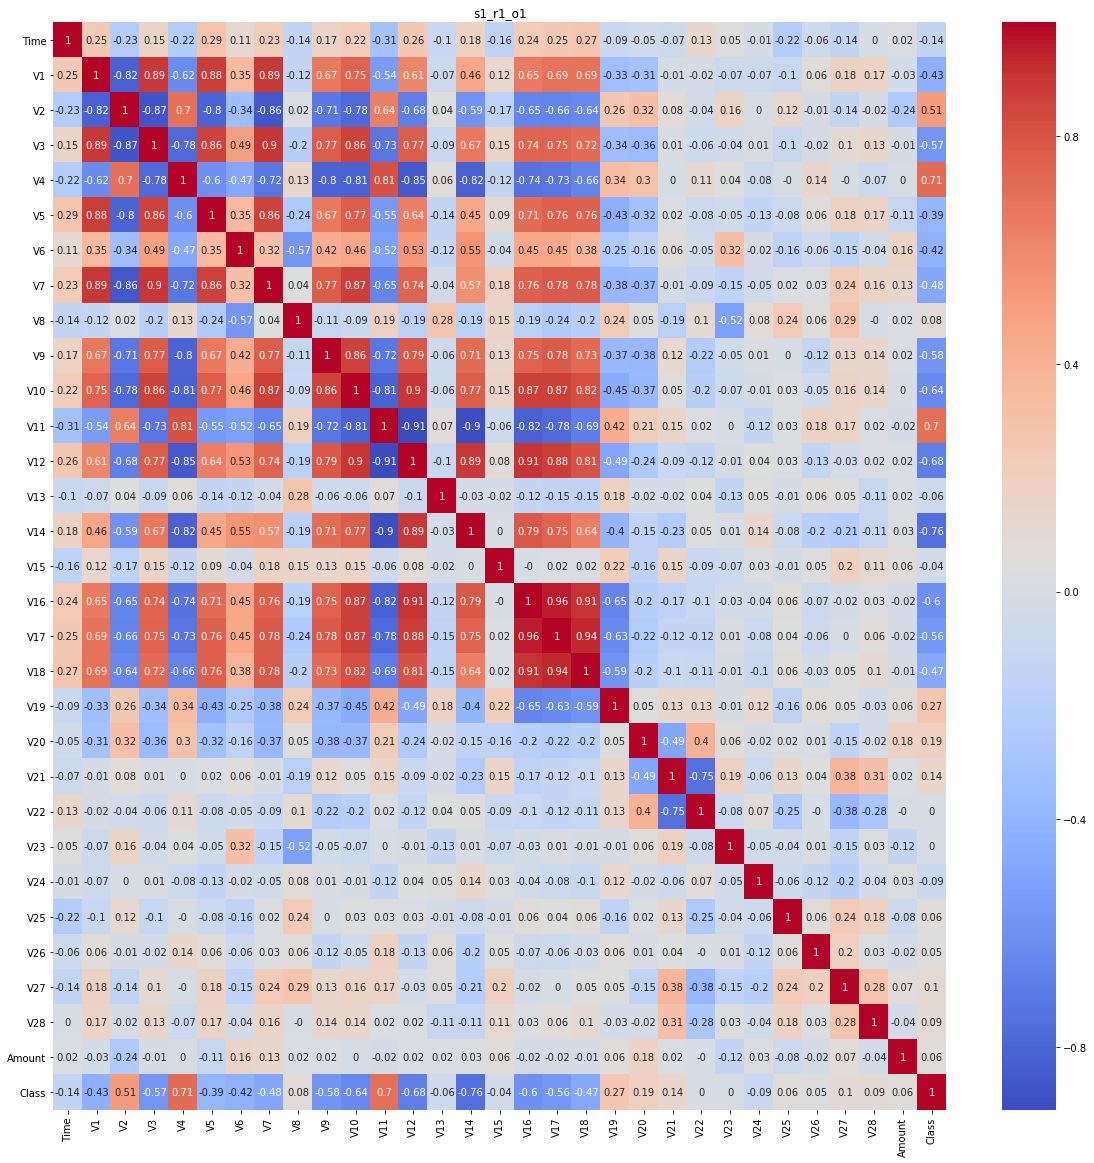

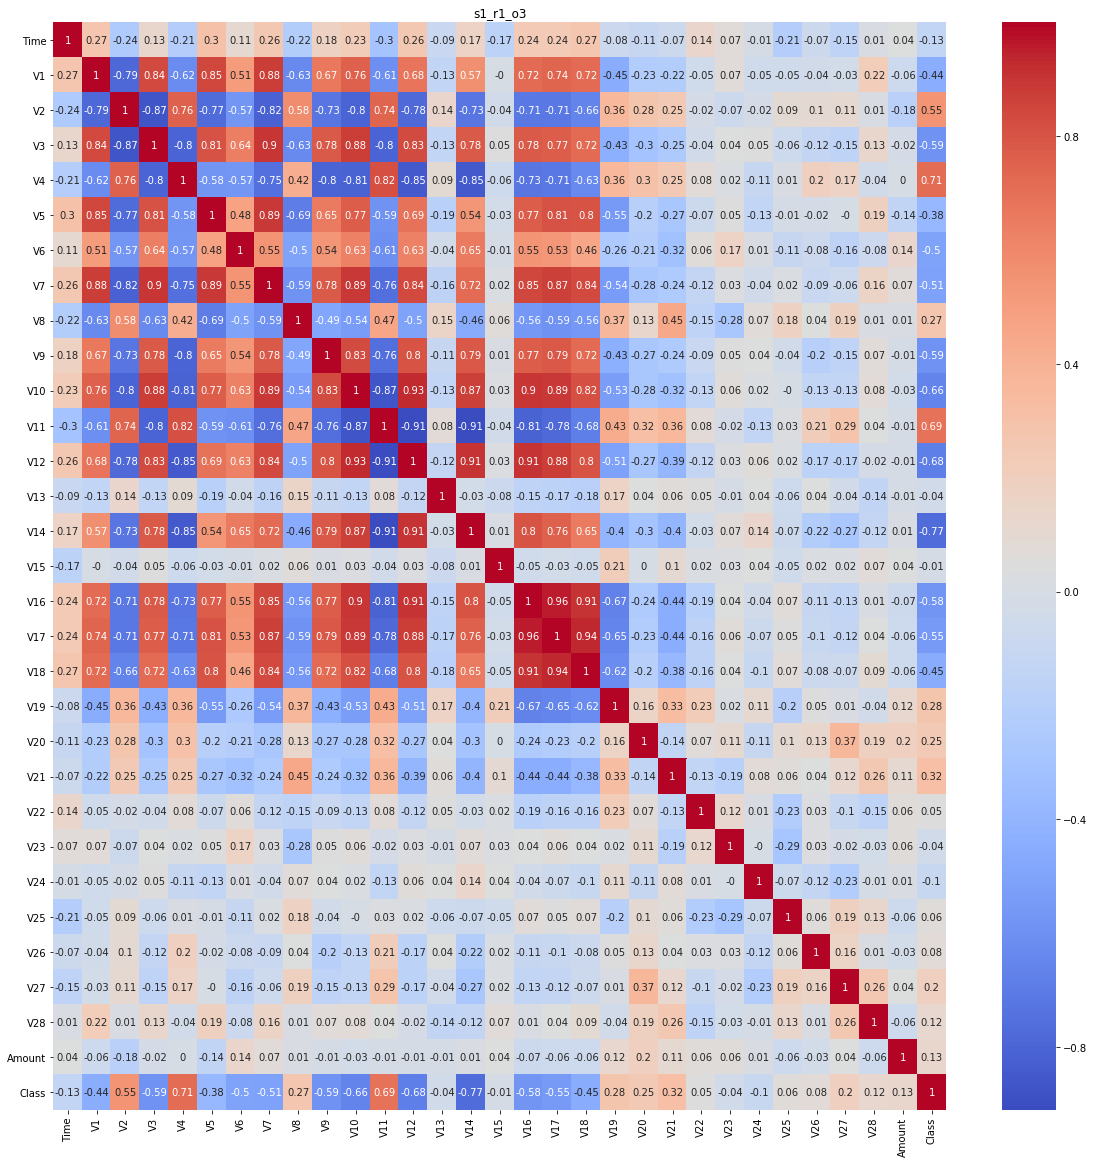

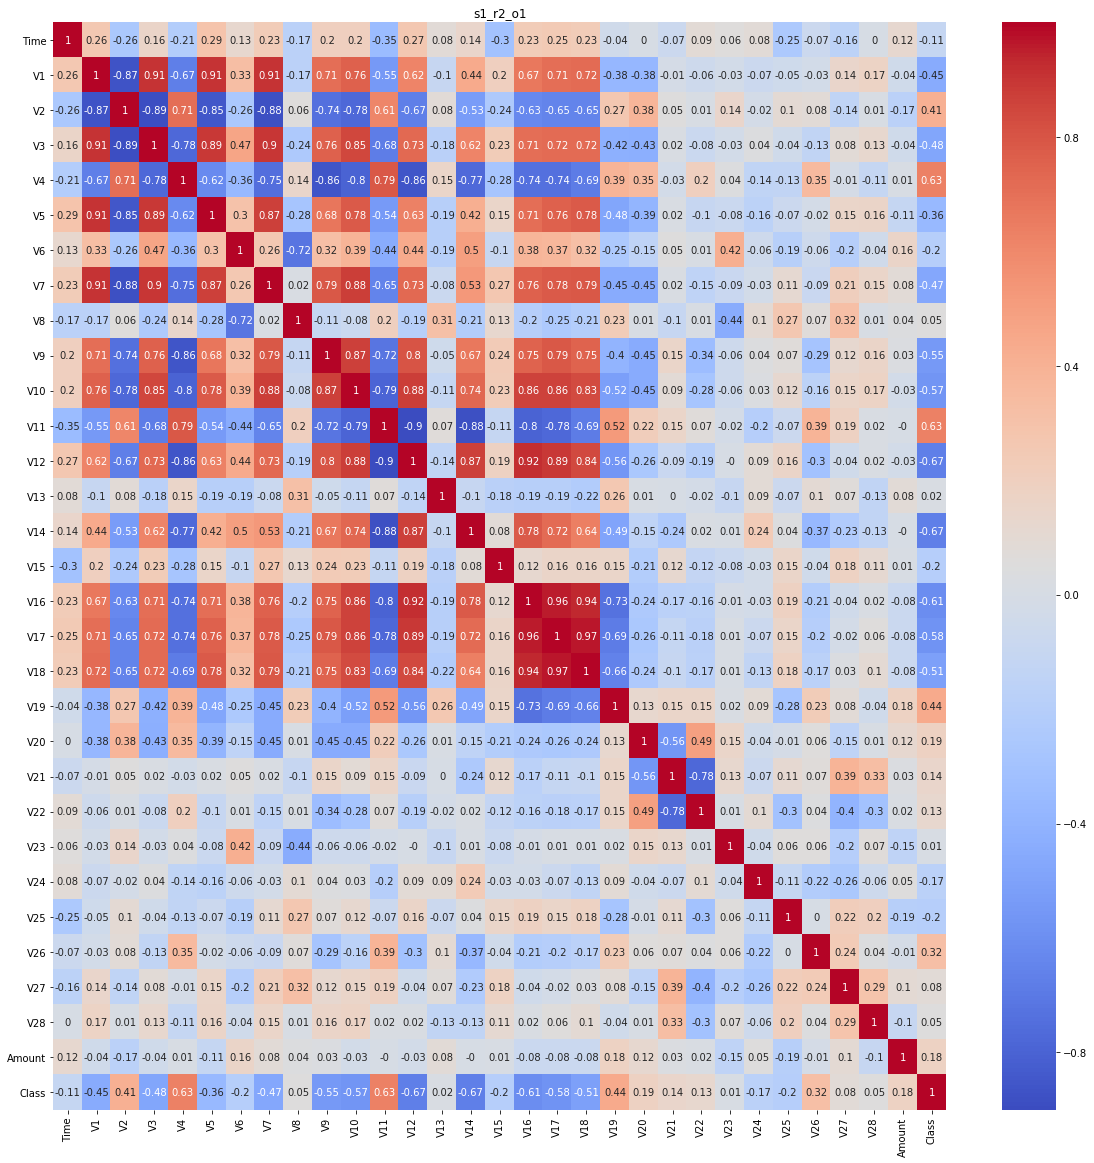

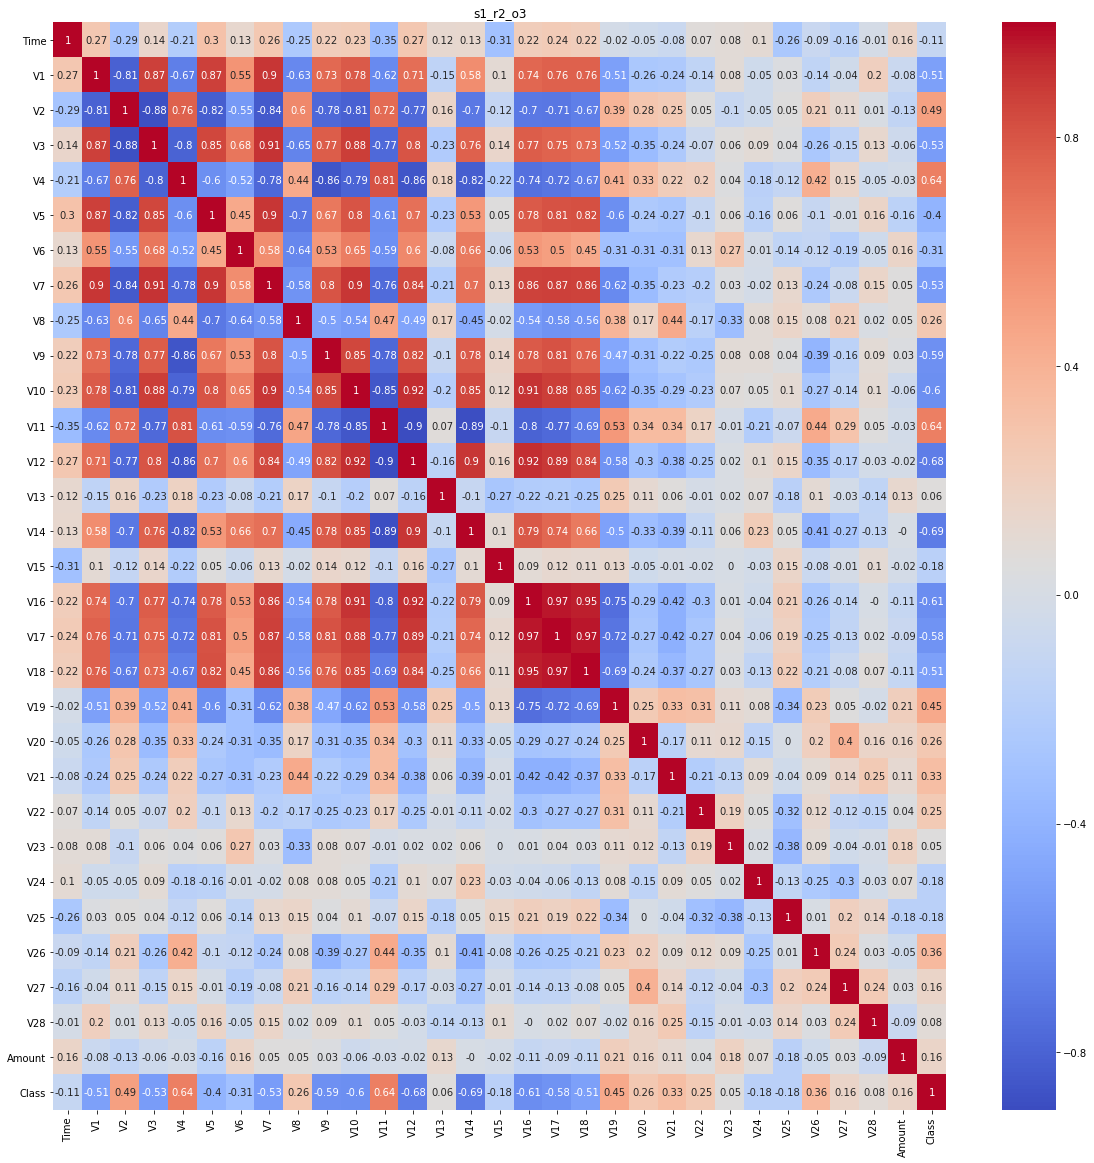

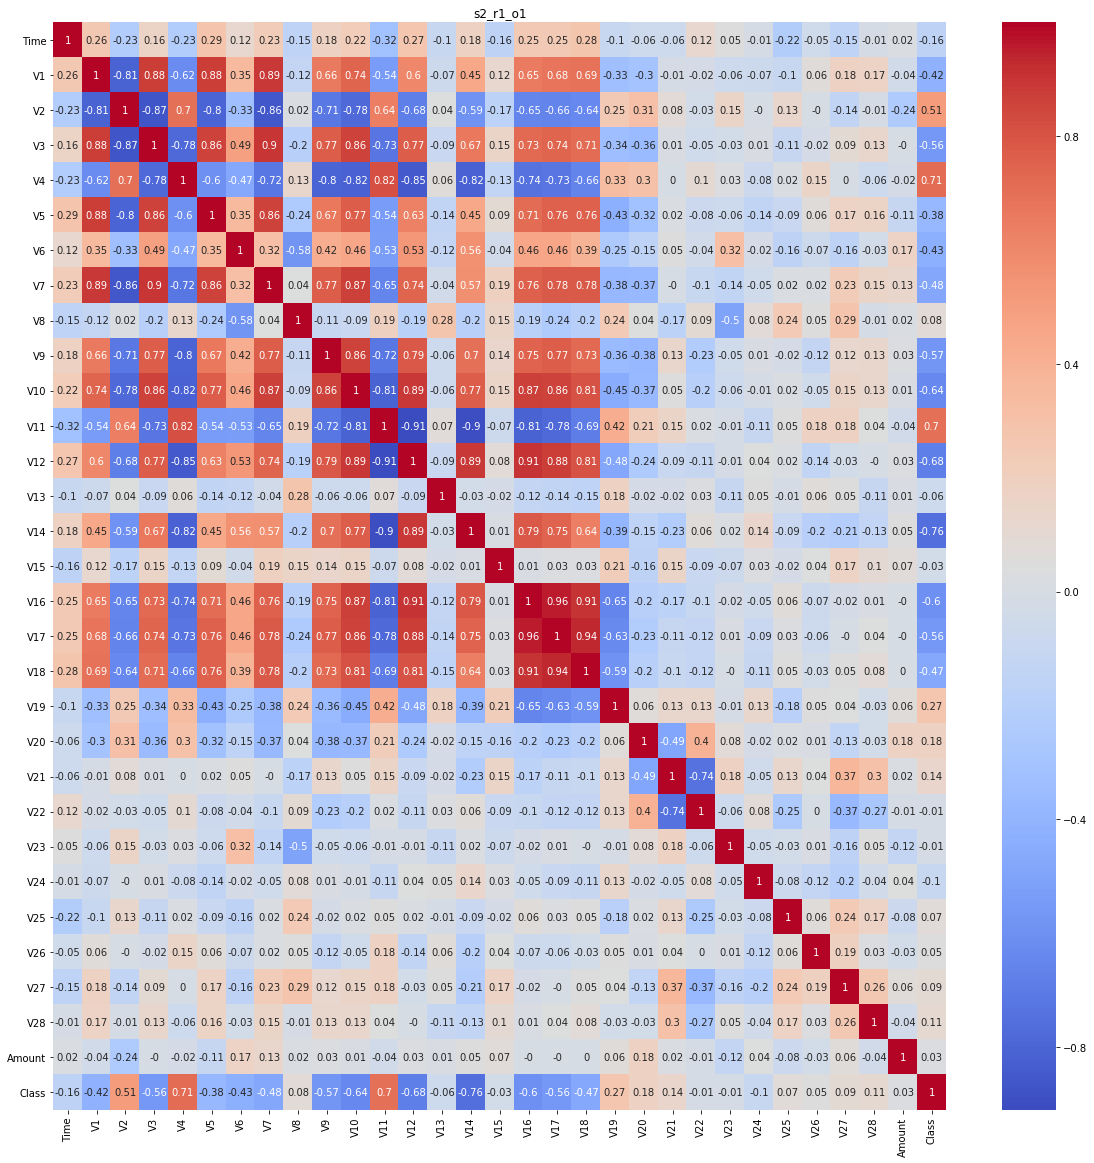

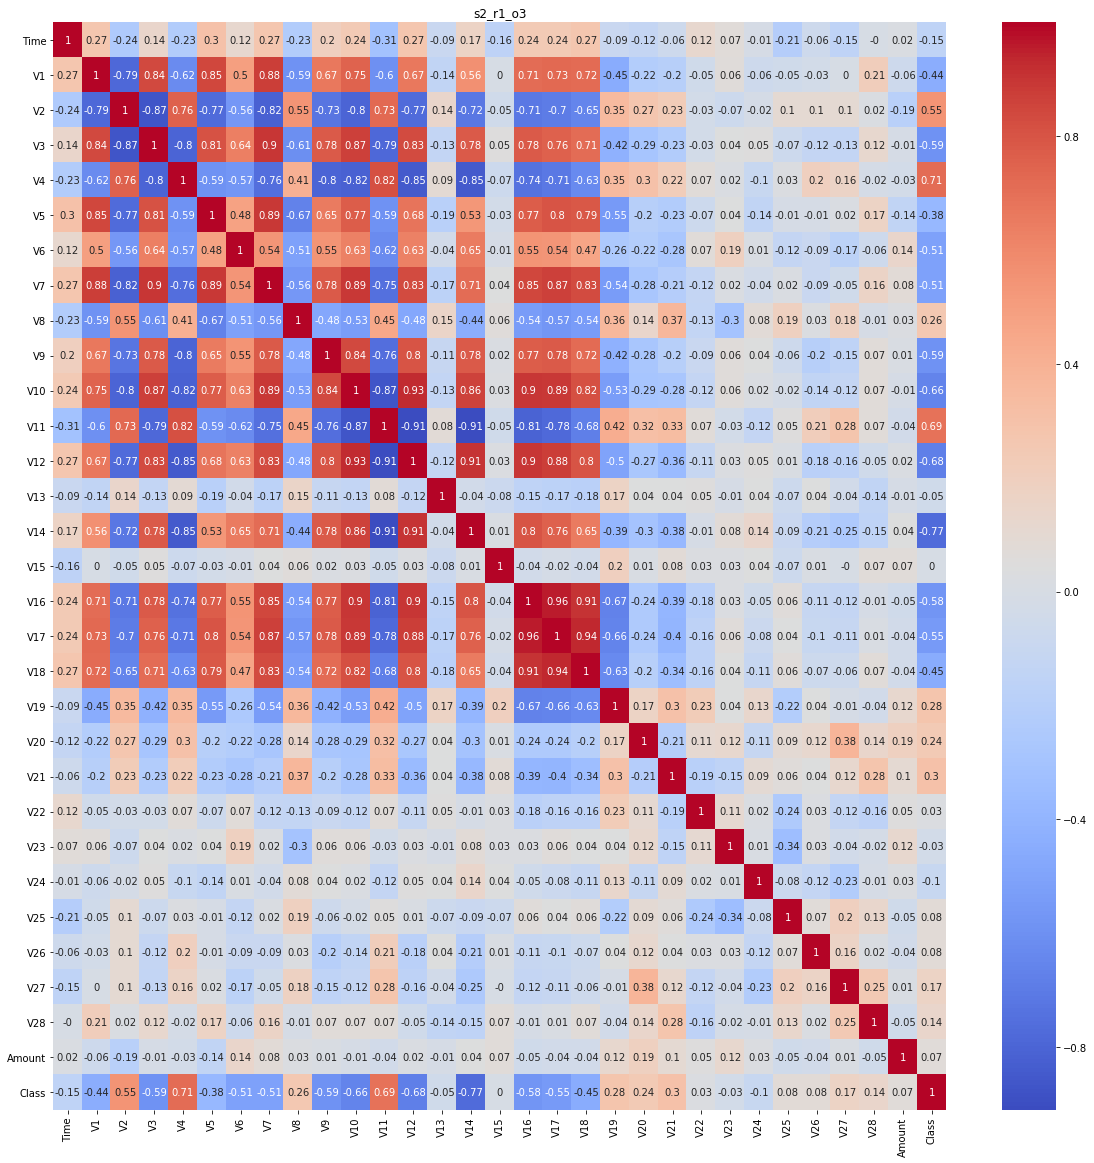

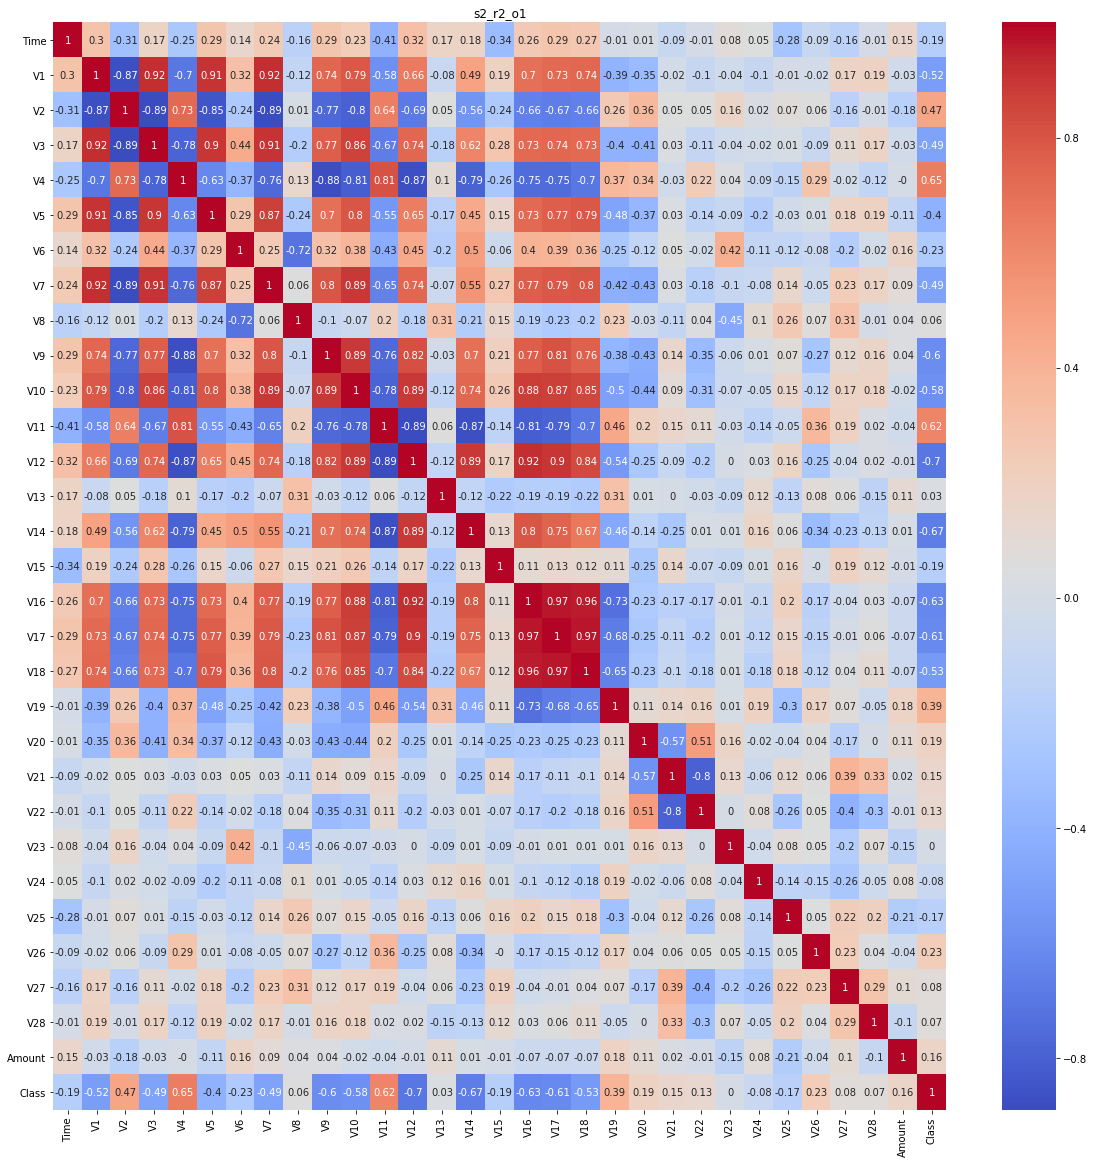

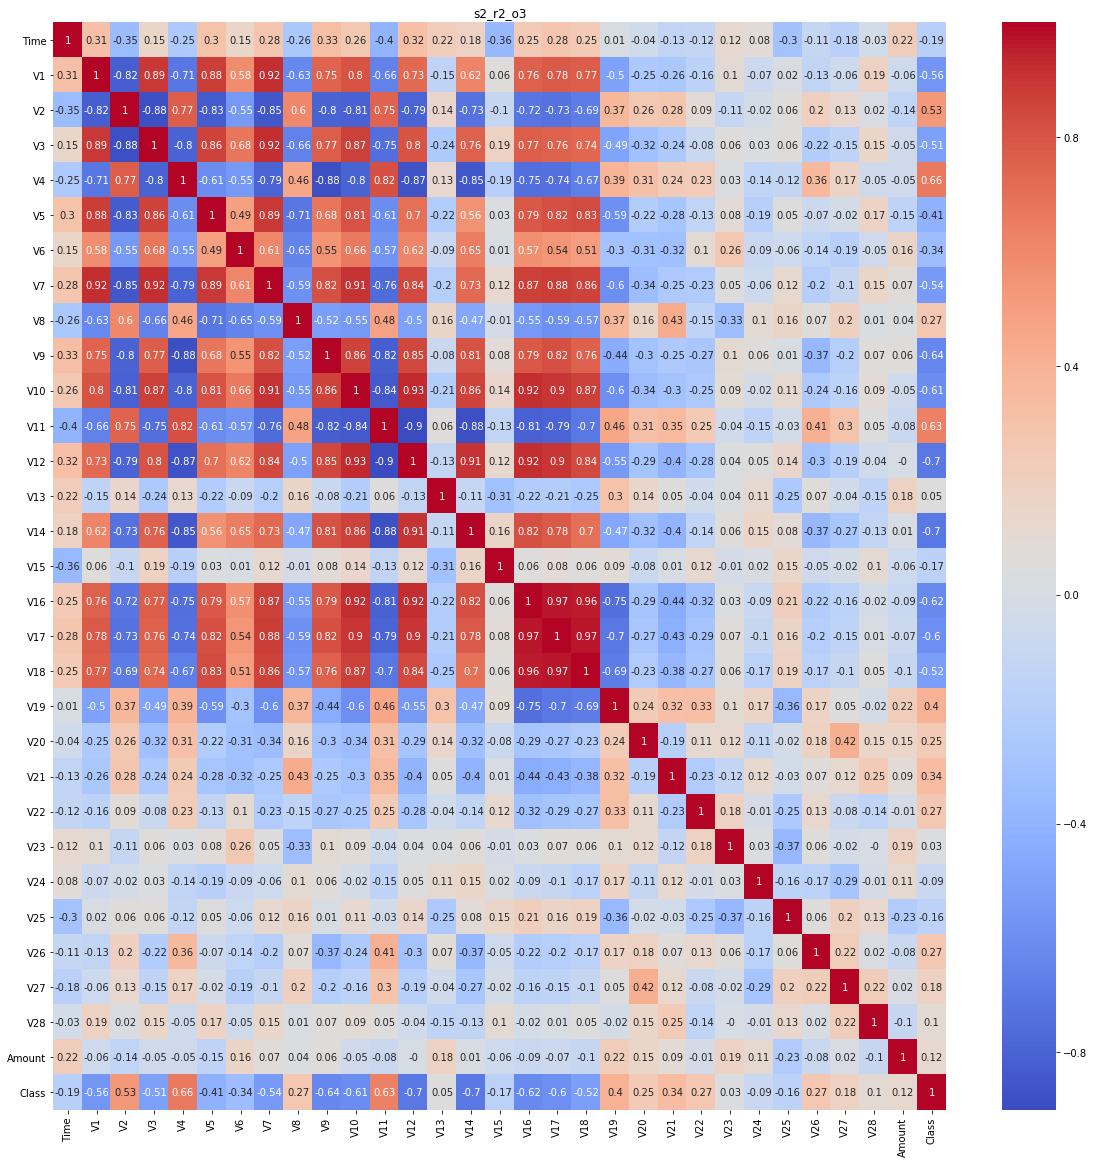

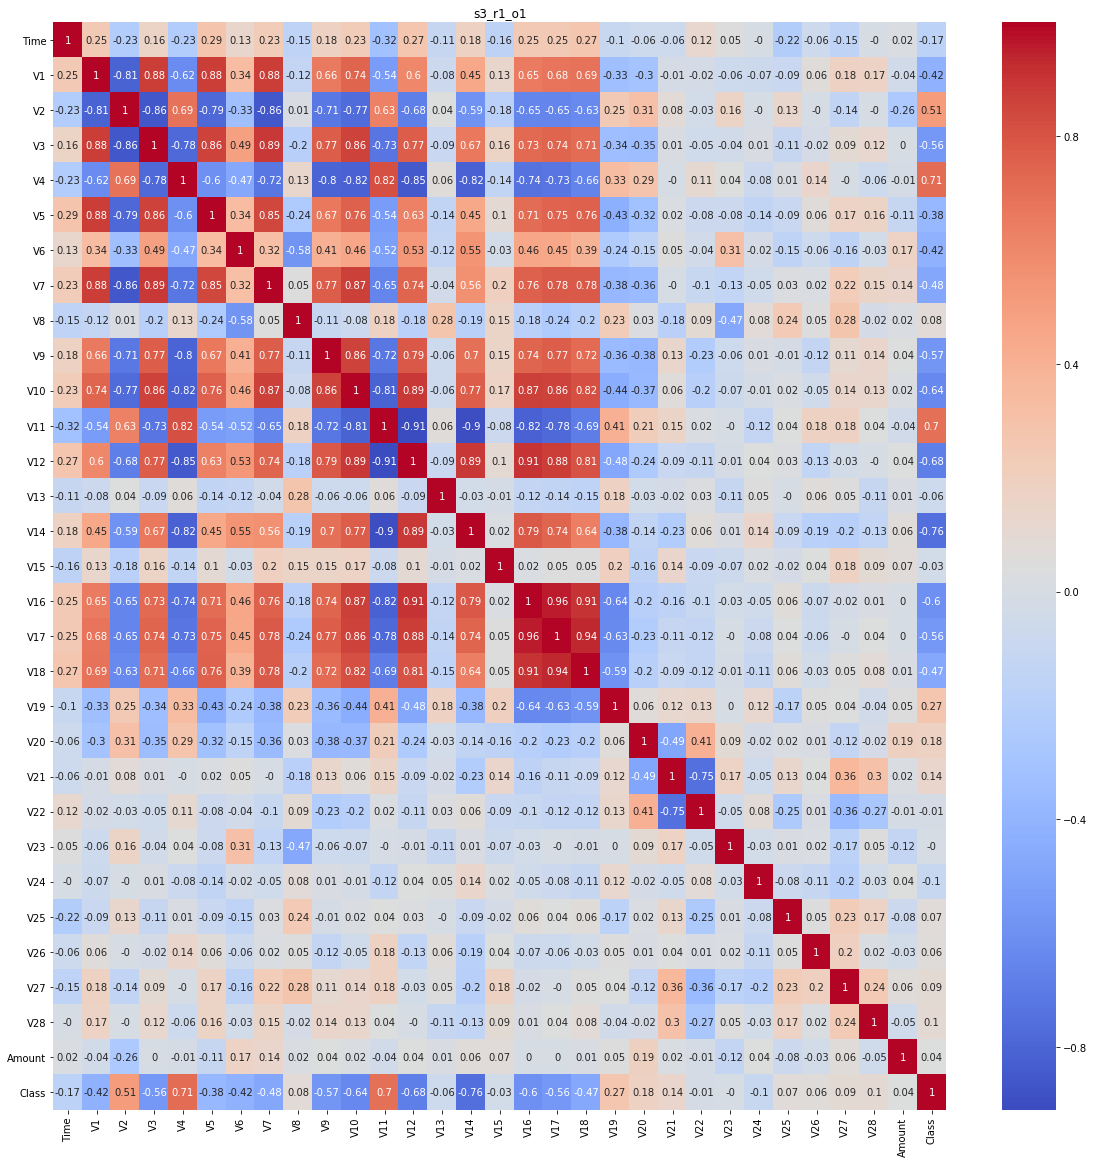

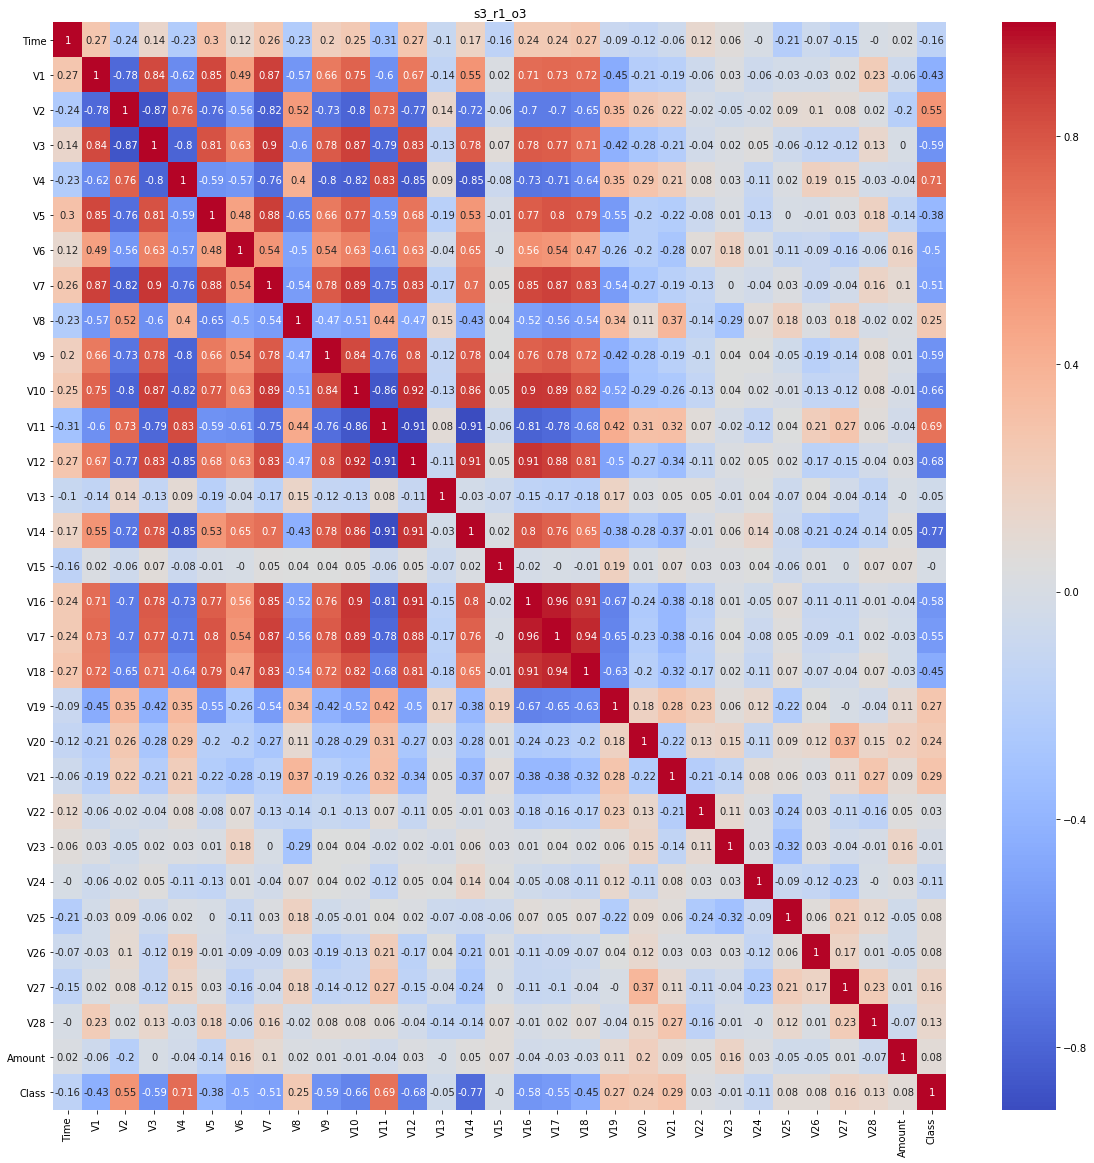

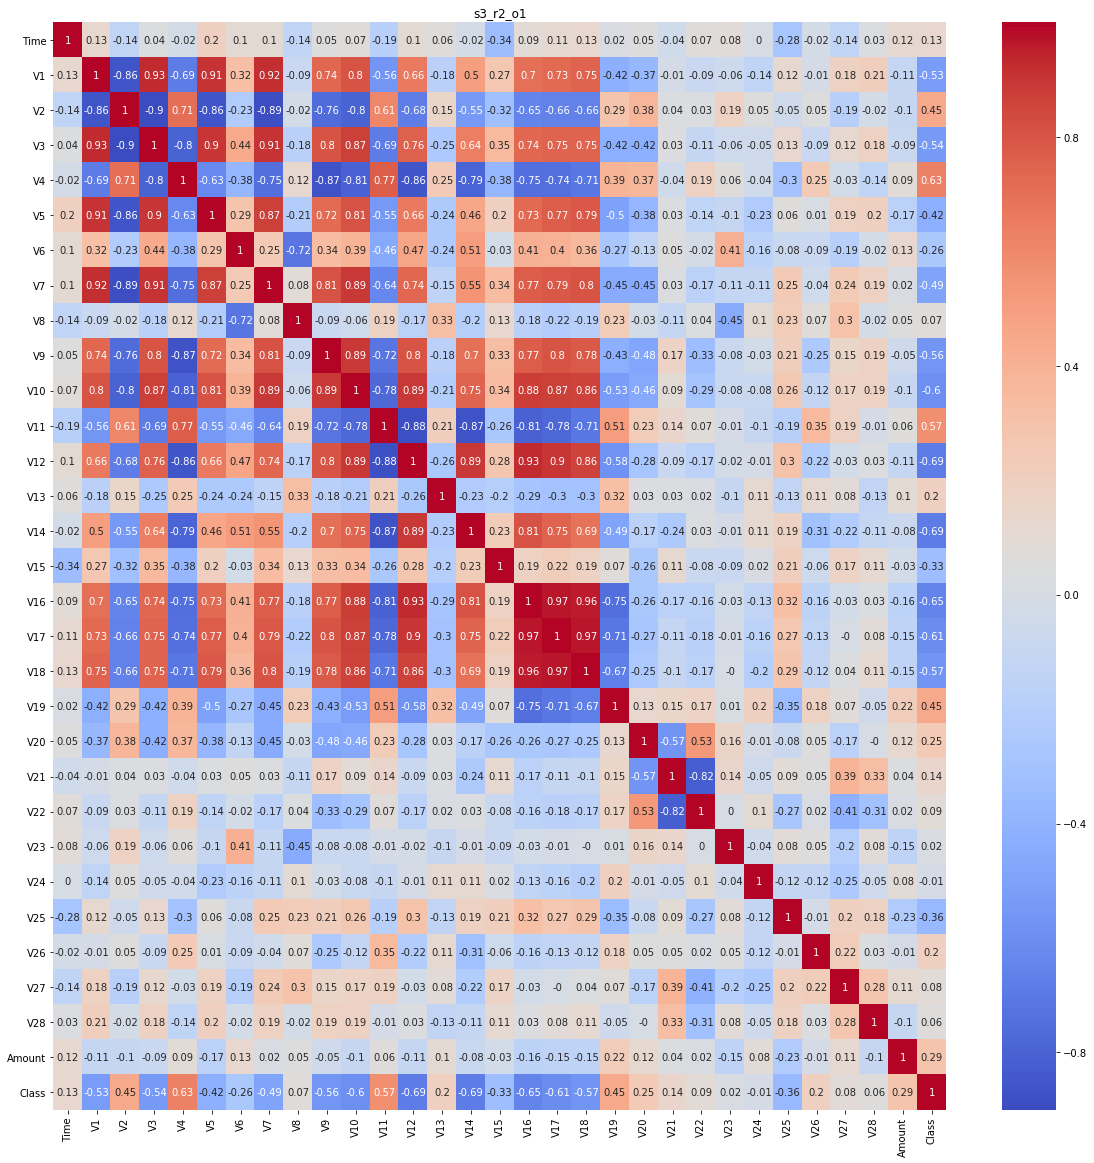

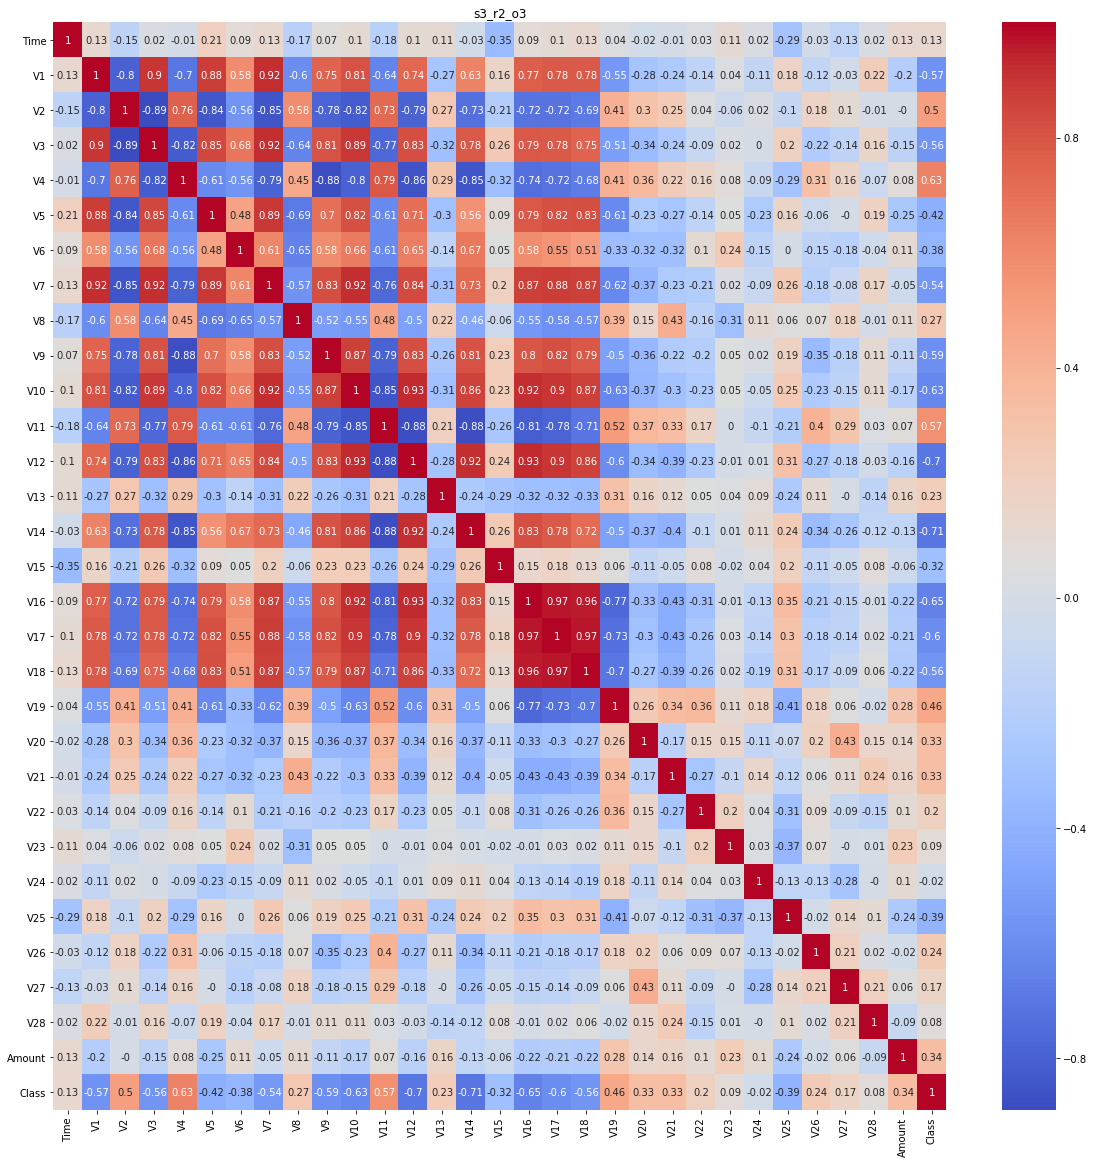

In [88]:
# Plot heatmaps for each version of the data
for key in sorted(outlier_removed_data.keys()):
    drawHeatMap(outlier_removed_data, key)

All versions of the data have multicolinarity. I will try to fix this with PCA.

## Principal component analysis

In this section I will perform PCA on each of the 16 versions of the data. My process for each version of the data will be as follows: <br><br>
1) Create a range from 1 to the amount of total features minus 1 (29). <br>
2) Create an instance of the PCA class for each number in the range with the number of components set to the before mentioned number. <br>
4) Fit each PCA instance to the data. <br>
5) Find the sum of the total explained variance for each PCA instance. <br>
6) Plot the results <br>
7) Examine plots to see where they platue and select that many components.<br>
8) Record a list of components for each version of the data

I will be writing a function to do steps 1 through 6.

# PCA & Matplotlib

In [89]:
# Function for steps 1 - 8
def PCA_Plot(key):
    
    # Get X
    X_= outlier_removed_data[key][0]
    
    # Create list to store sums of explained variance ratios
    evrs = []
    
    # Create a range from 1 to 29
    r = range(5,30)
    
    # Create an instance of the PCA class for each number in r
    for n in r:
        pca = PCA(n)
        
        # Fit pca to the data and transform
        X_pca = pca.fit_transform(X_)

        # Append the sum of explained variance ratio to the list "evrs"
        evrs.append(sum(pca.explained_variance_ratio_))
        
    # Plot the results
    plt.figure(figsize=(15,4))
    plt.plot(r, evrs, color='green', label='Sums of explained variance ratios')
    plt.title(key + ' Explained variance')
    plt.xlabel('Number of principle components')
    plt.xticks(r)
    plt.yticks(np.array(np.arange(round(evrs[0], 1)-0.1, 1.09, step=0.1)))
    plt.legend()
    plt.grid()
    plt.show()
    

Now I will manually go through each version and record where each graph plateus. I will use a list to record my observations.

Warning: this cell took 8 minutes to run!

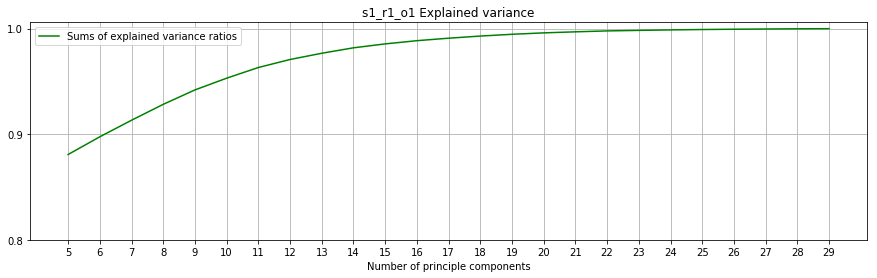

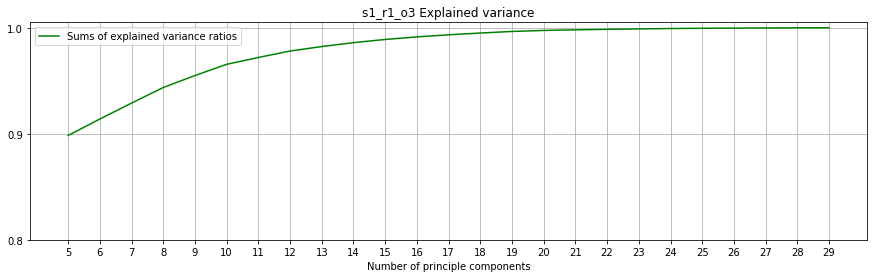

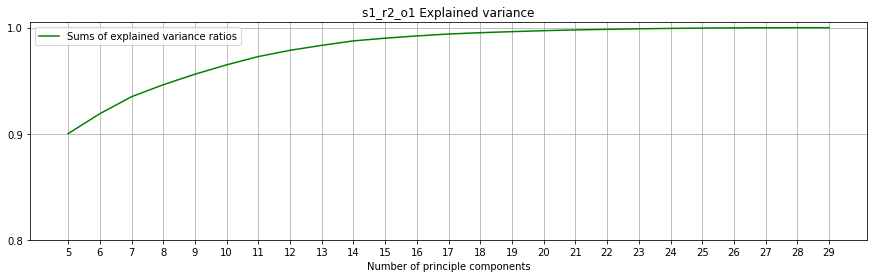

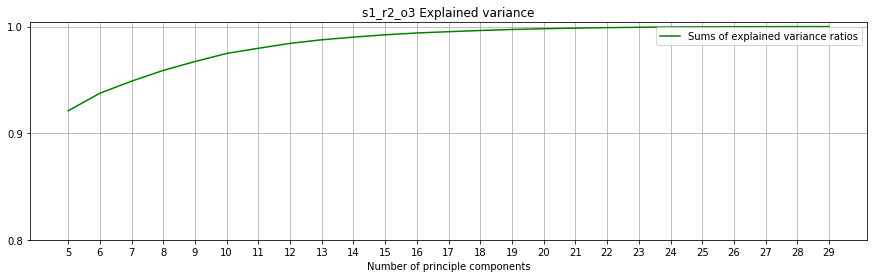

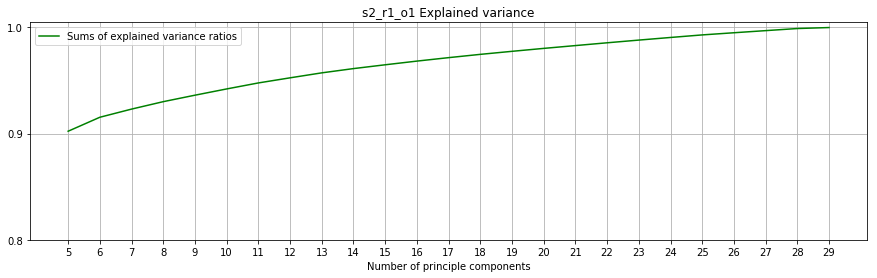

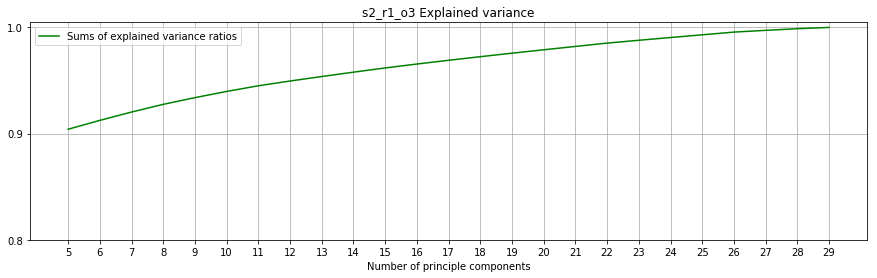

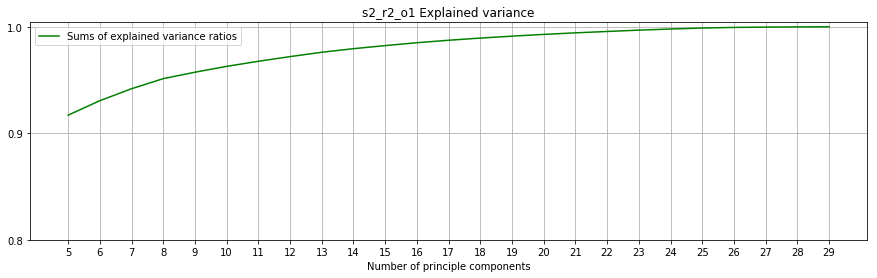

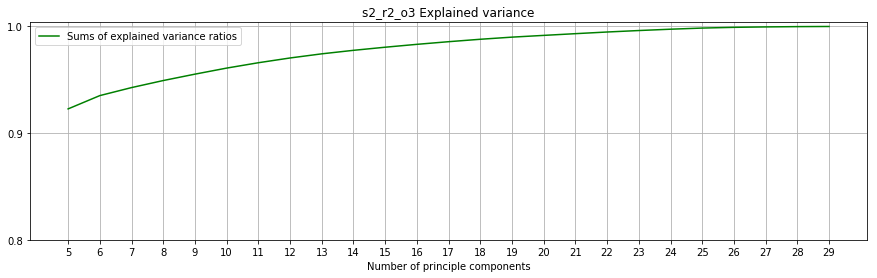

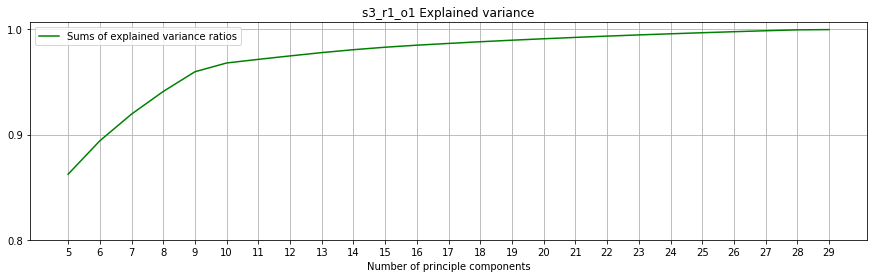

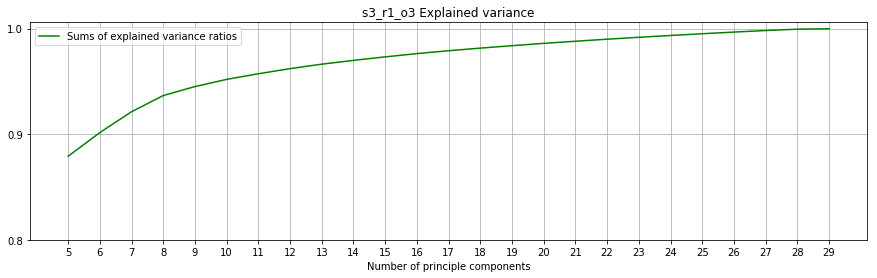

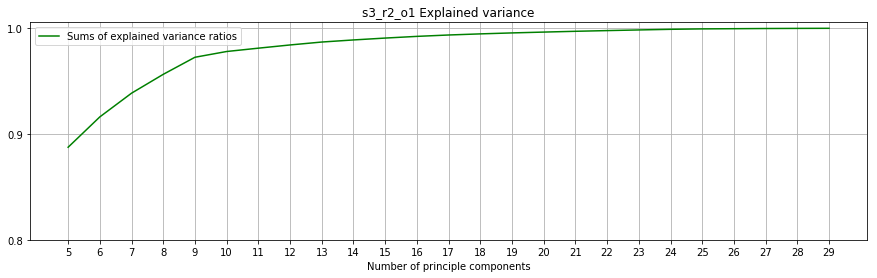

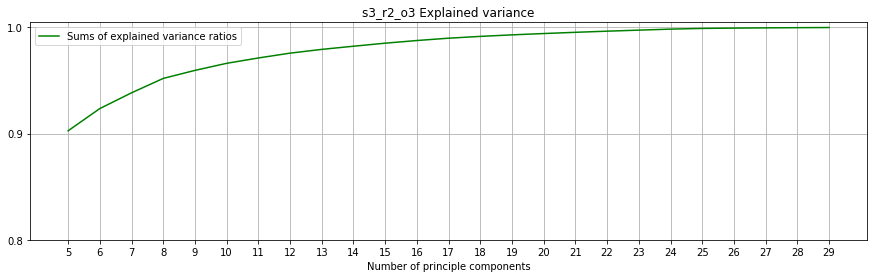

It took 621.9599413871765 seconds for this cell to run


In [90]:
# Run function on every version of the data and time this cell

t1 = time.time()

for key in sorted(outlier_removed_data.keys()):
    PCA_Plot(key)
    
t2 = time.time()

print('It took {} seconds for this cell to run'.format(t2-t1))

In [103]:
# Number of components to use in order of sorted keys
n_components = [19, 18, 17, 16, 26, 26, 21, 22, 23, 25, 17, 20]

# zip sorted keys of outlier removed data with n_components
olr_keys_n_components = zip(sorted(outlier_removed_data.keys()), n_components)

In [104]:
# Save olr_keys_n_components
pickle_out = open("Modeling/olr_keys_n_components.pickle", "wb")
pickle.dump(olr_keys_n_components, pickle_out)
pickle_out.close()

Now for each key in outlier_removed_data I will create a key in a new dictionary (pc_data) where I will store a PCA transformed version of the train and test data. I will add a suffix '_p' to the data just in case to help keep things organized.

In [105]:
# Dictionary for PCA transformed data
pc_data = {}

In [106]:
# Create a suffix to add to each key
suffix = '_p'

# Iterate through our list of n_components and through the sorted keys of outlier_removed_data
for key, n in olr_keys_n_components:
    
    # Retrieve data from outlier_removed_data
    X_ = outlier_removed_data[key][0]
    y_ = outlier_removed_data[key][1]
    
    # Create an instance of the PCA class with the right amount for n_components
    pca = PCA(n)
    
    # fit and transform data
    pc_X = pca.fit_transform(X_)
    
    # Turn data back into a dataframe
    pc_X = pd.DataFrame(pc_X, columns=range(n))

    
    # Add the newly transformed data too the dictionary pc_data
    pc_data[key + suffix] = (pc_X, y_)

Now I will examine the PCA transformed data for multicolinearity.

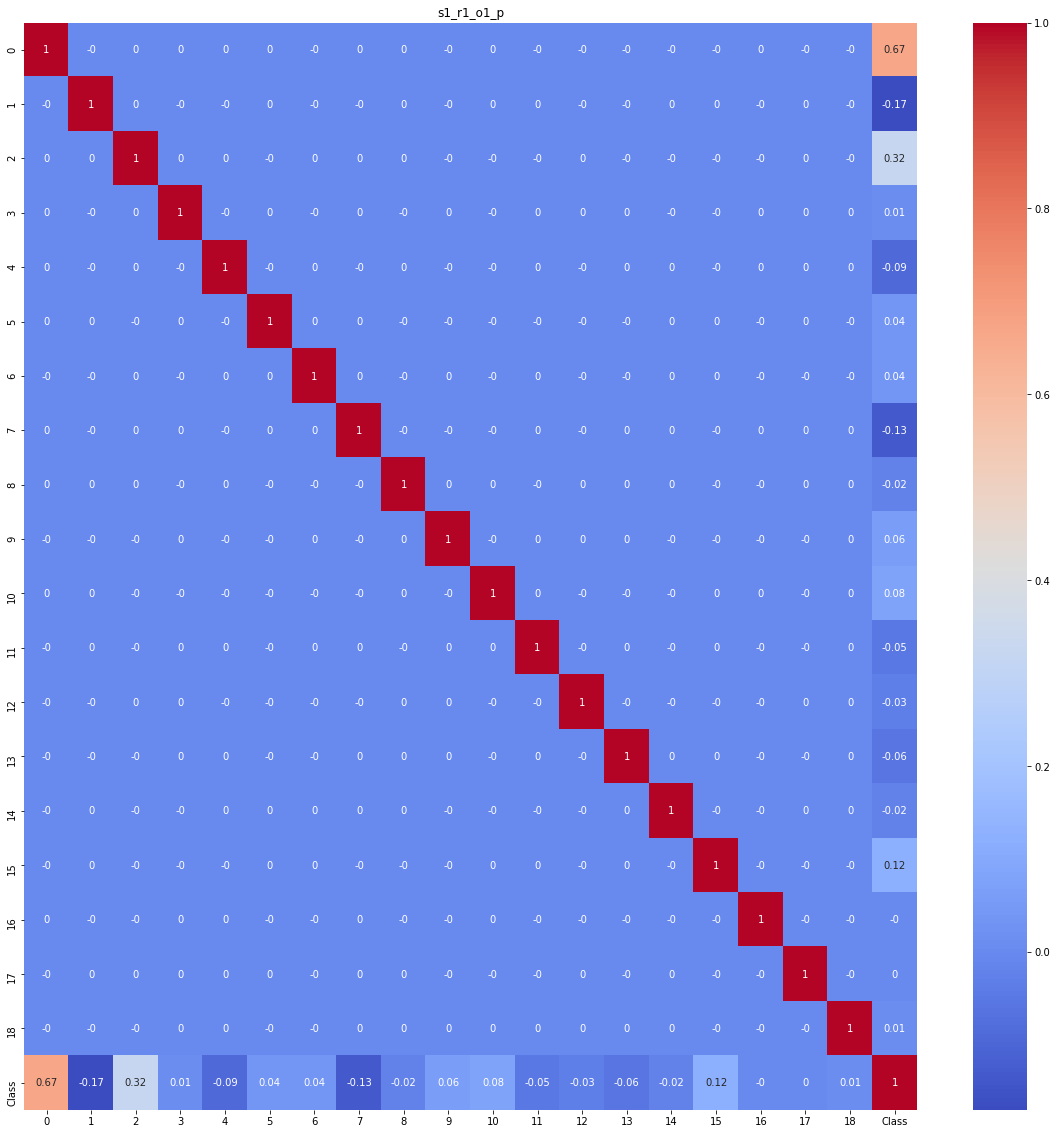

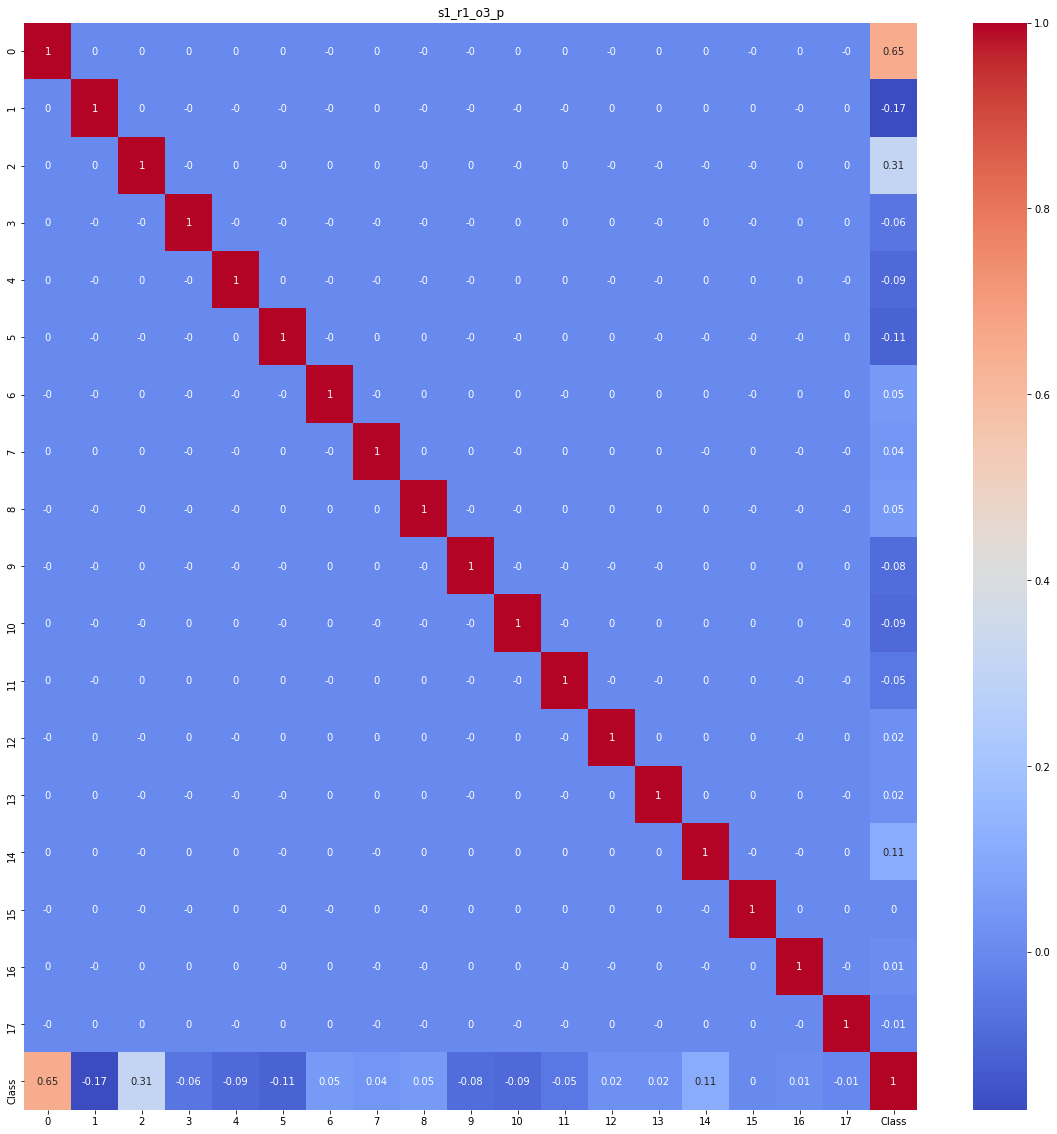

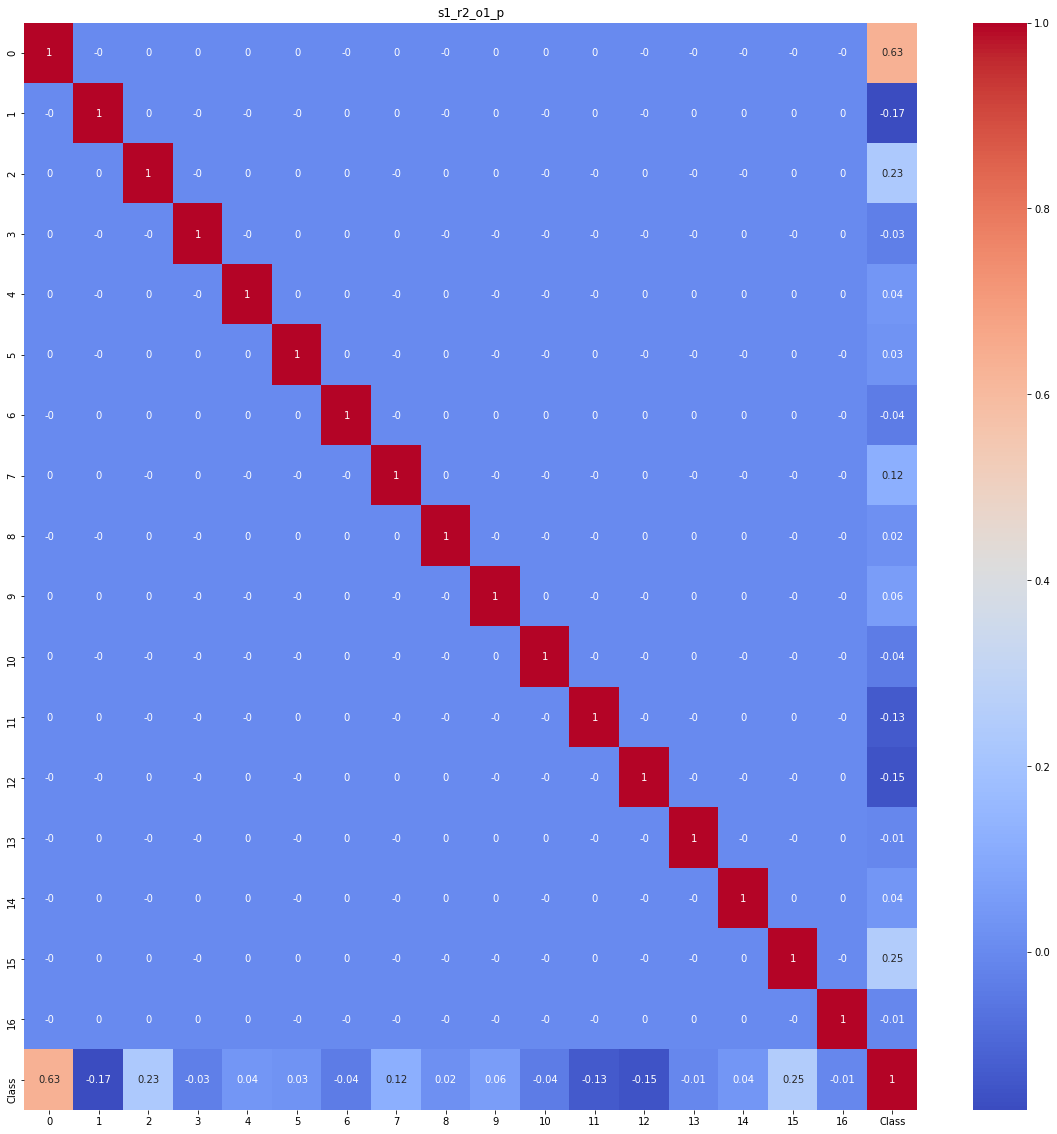

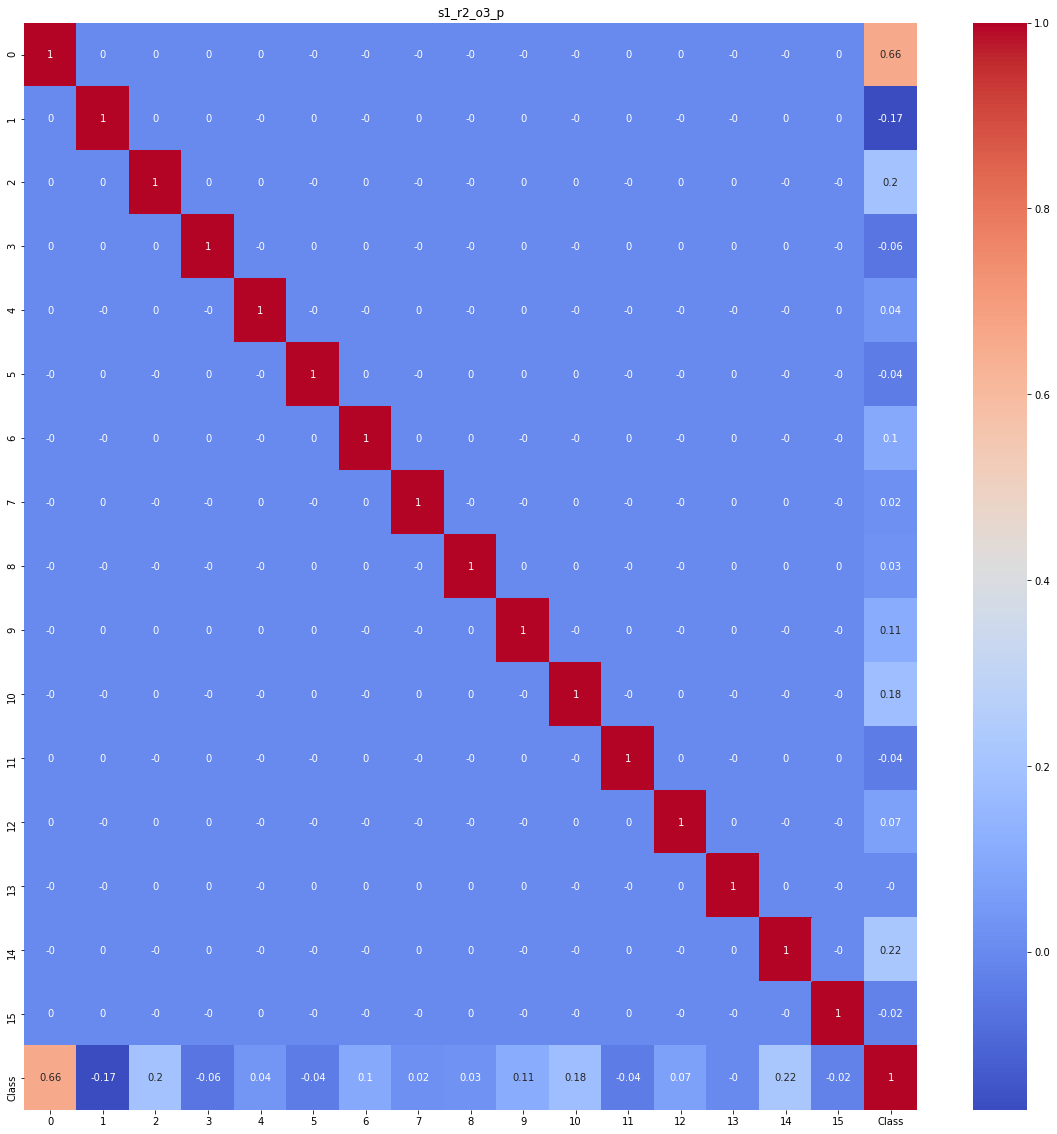

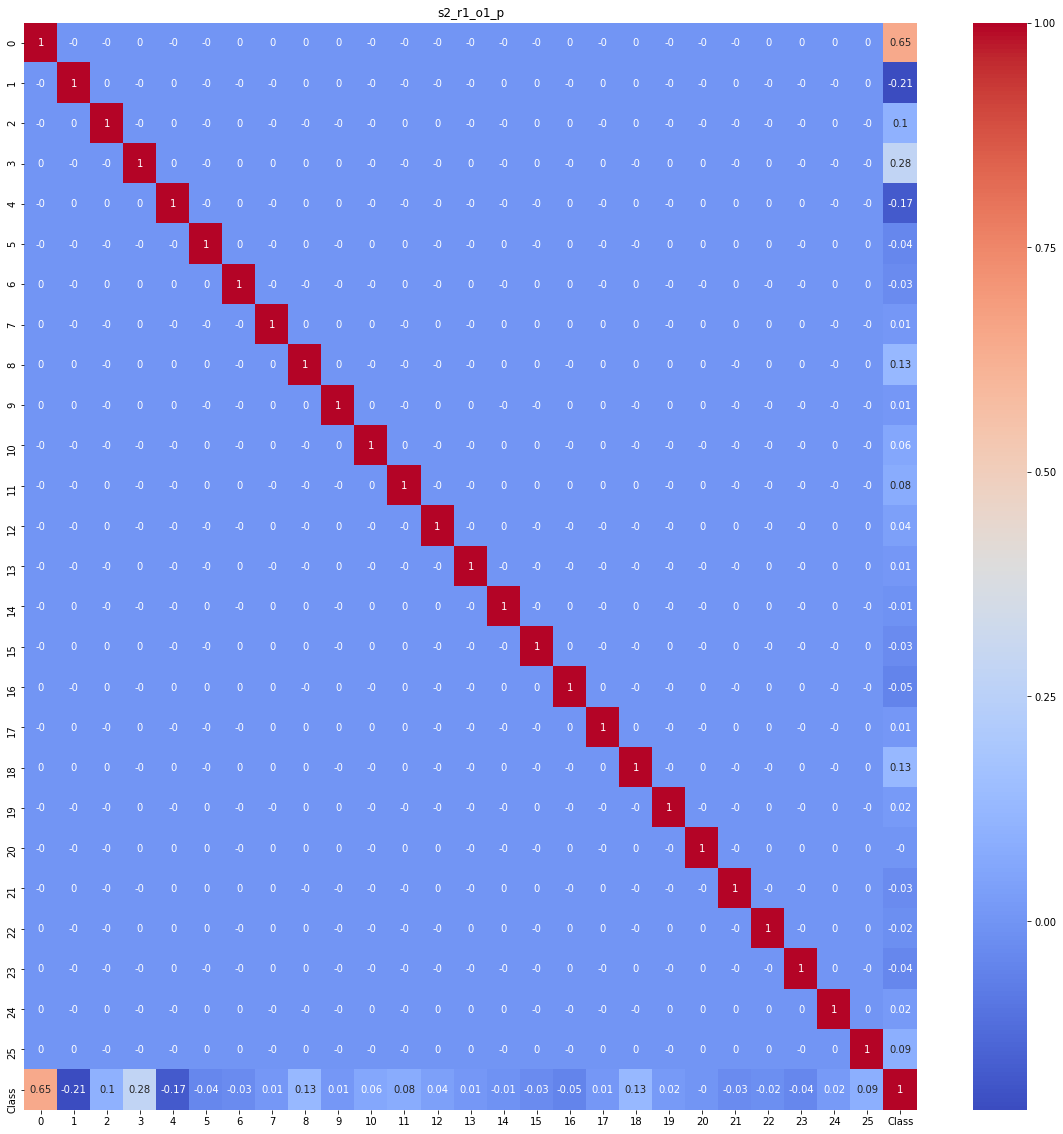

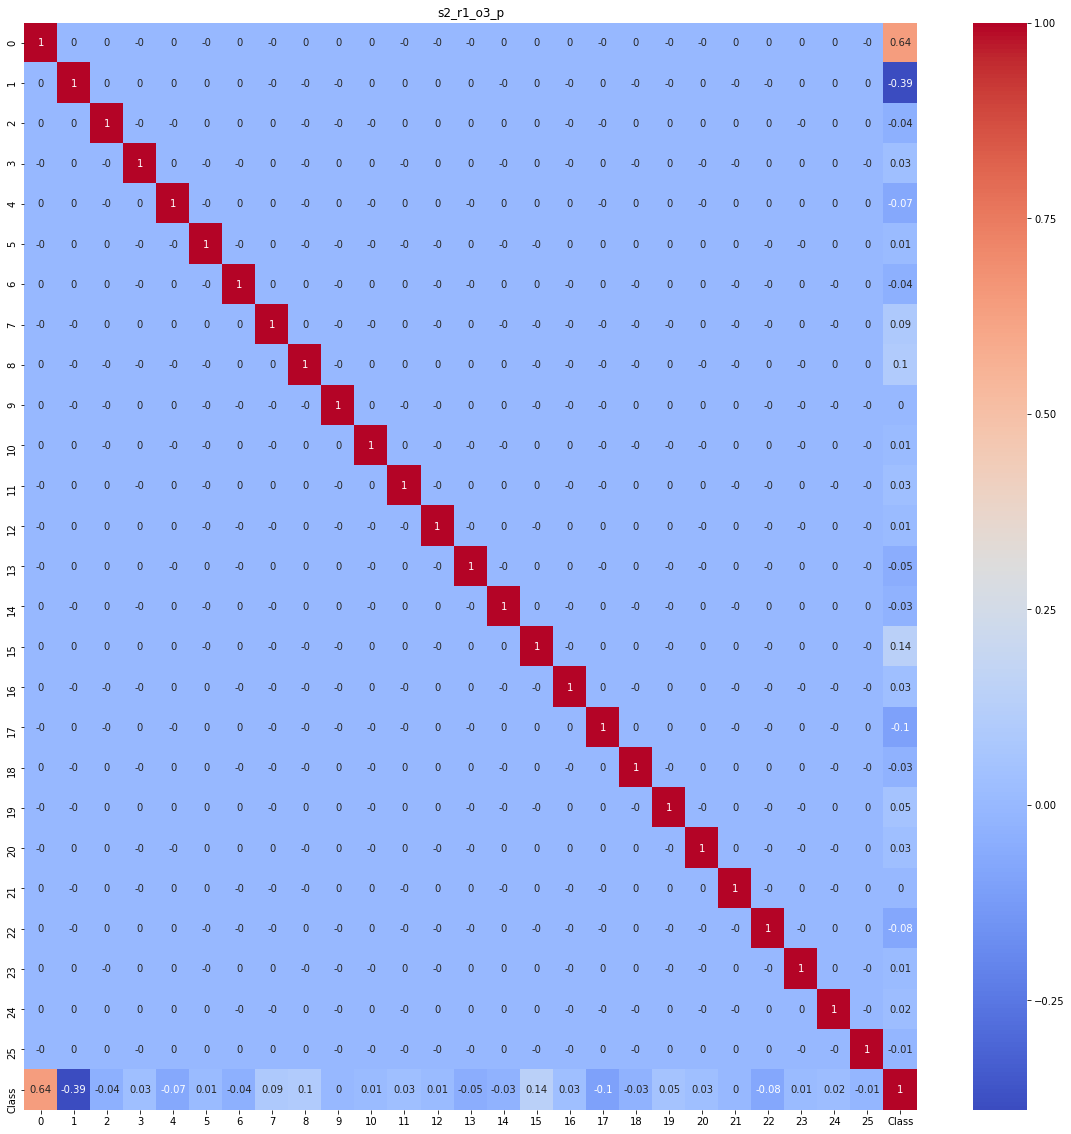

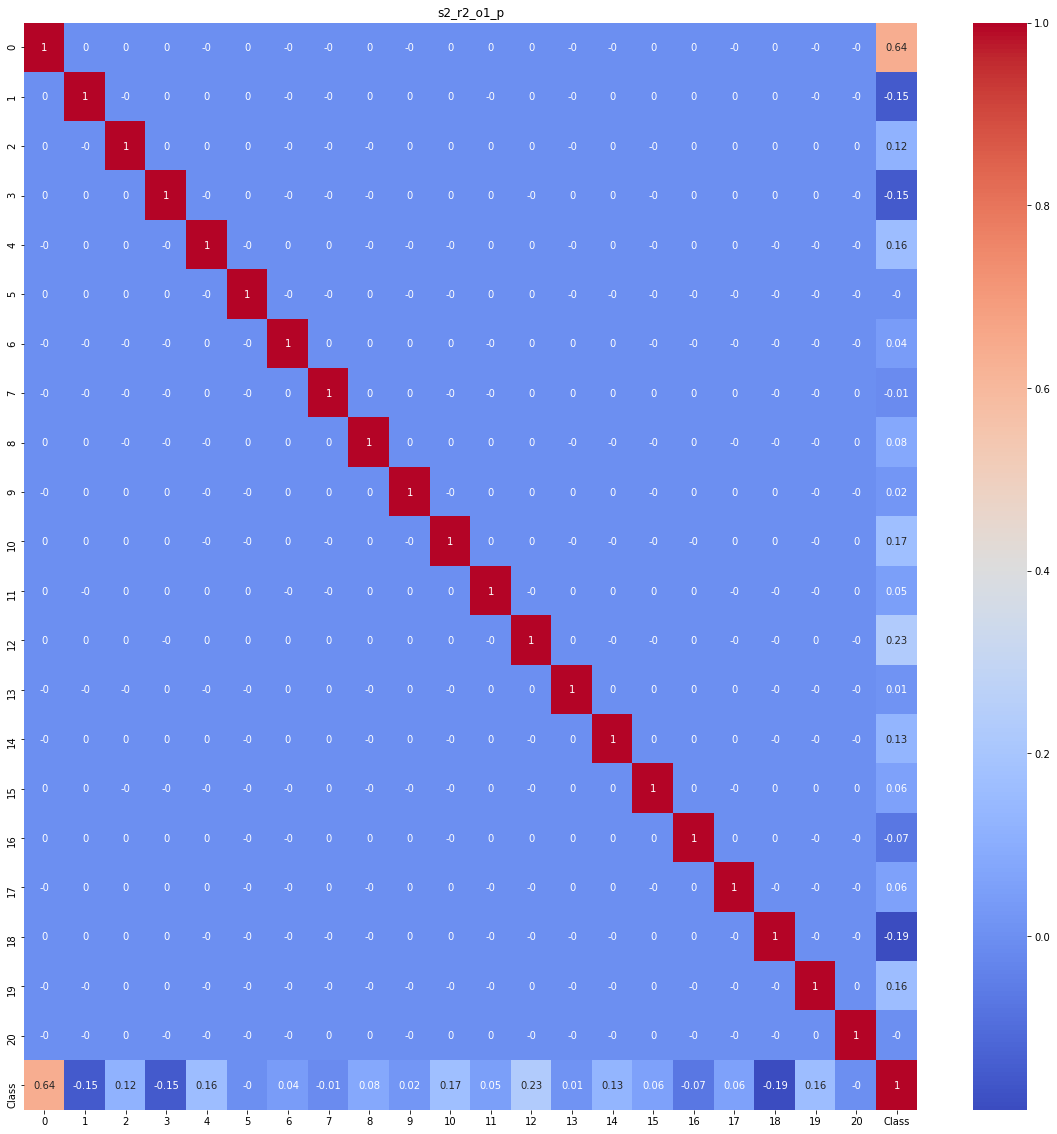

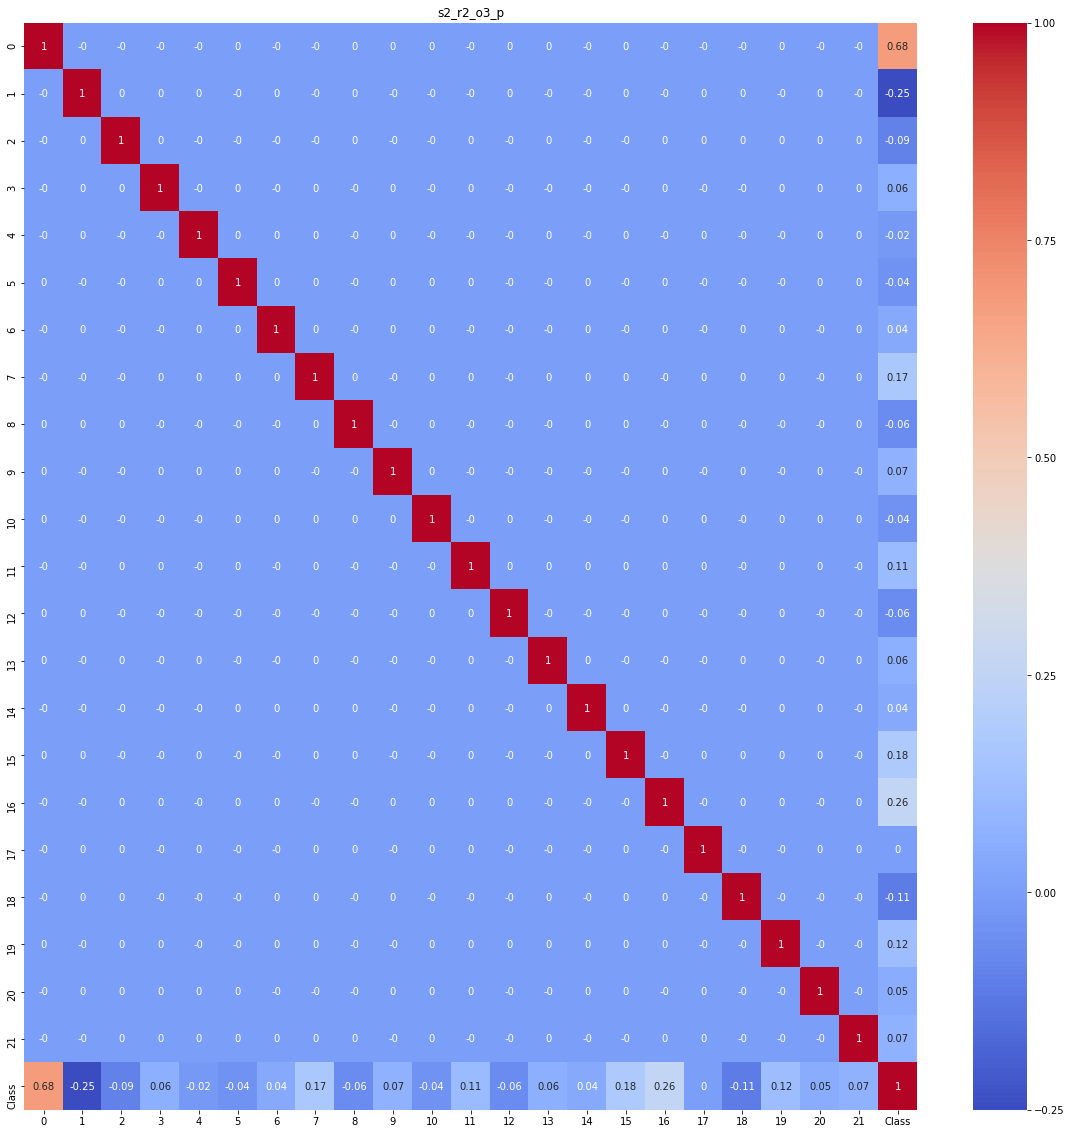

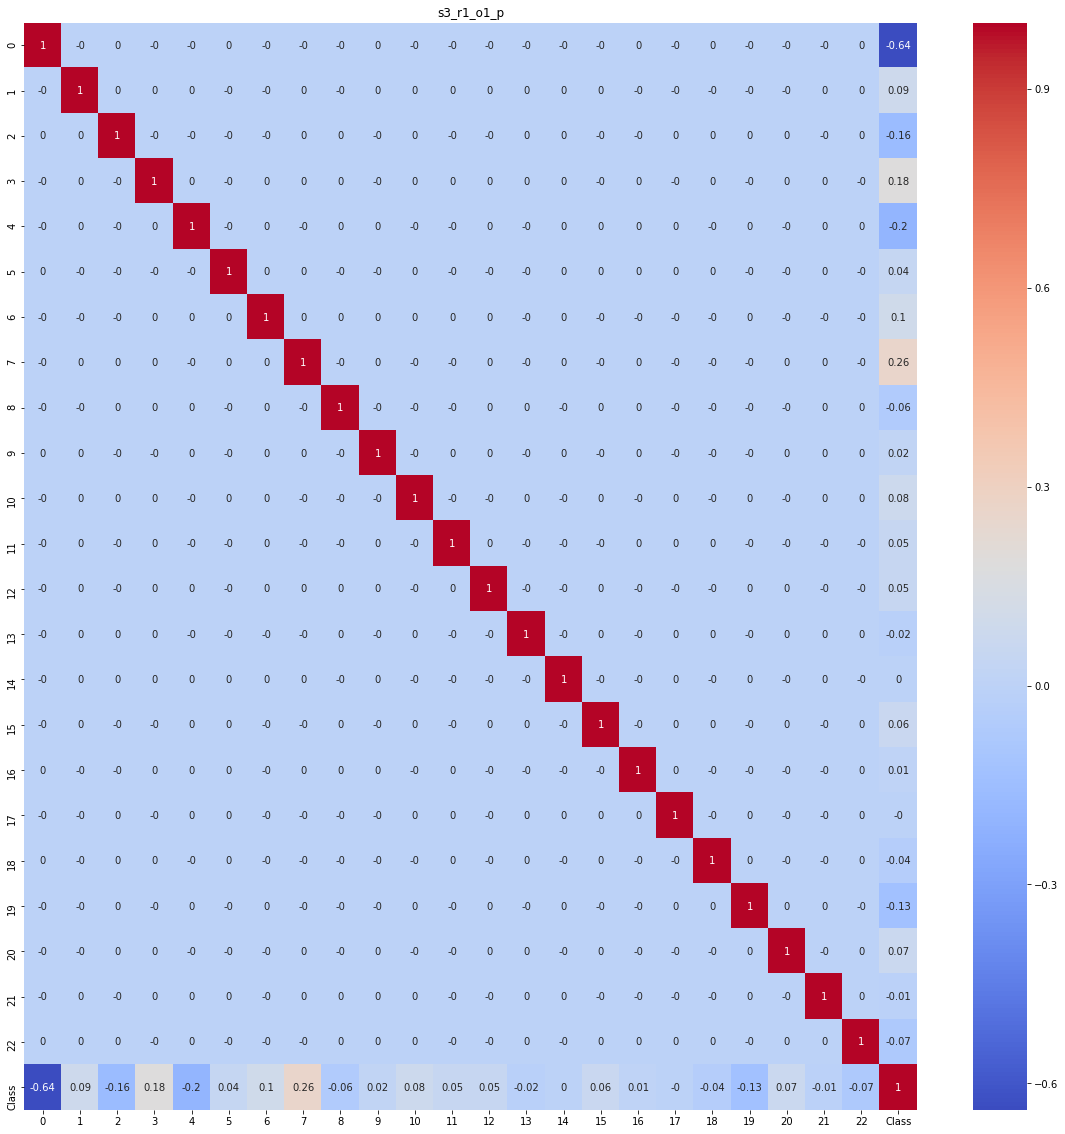

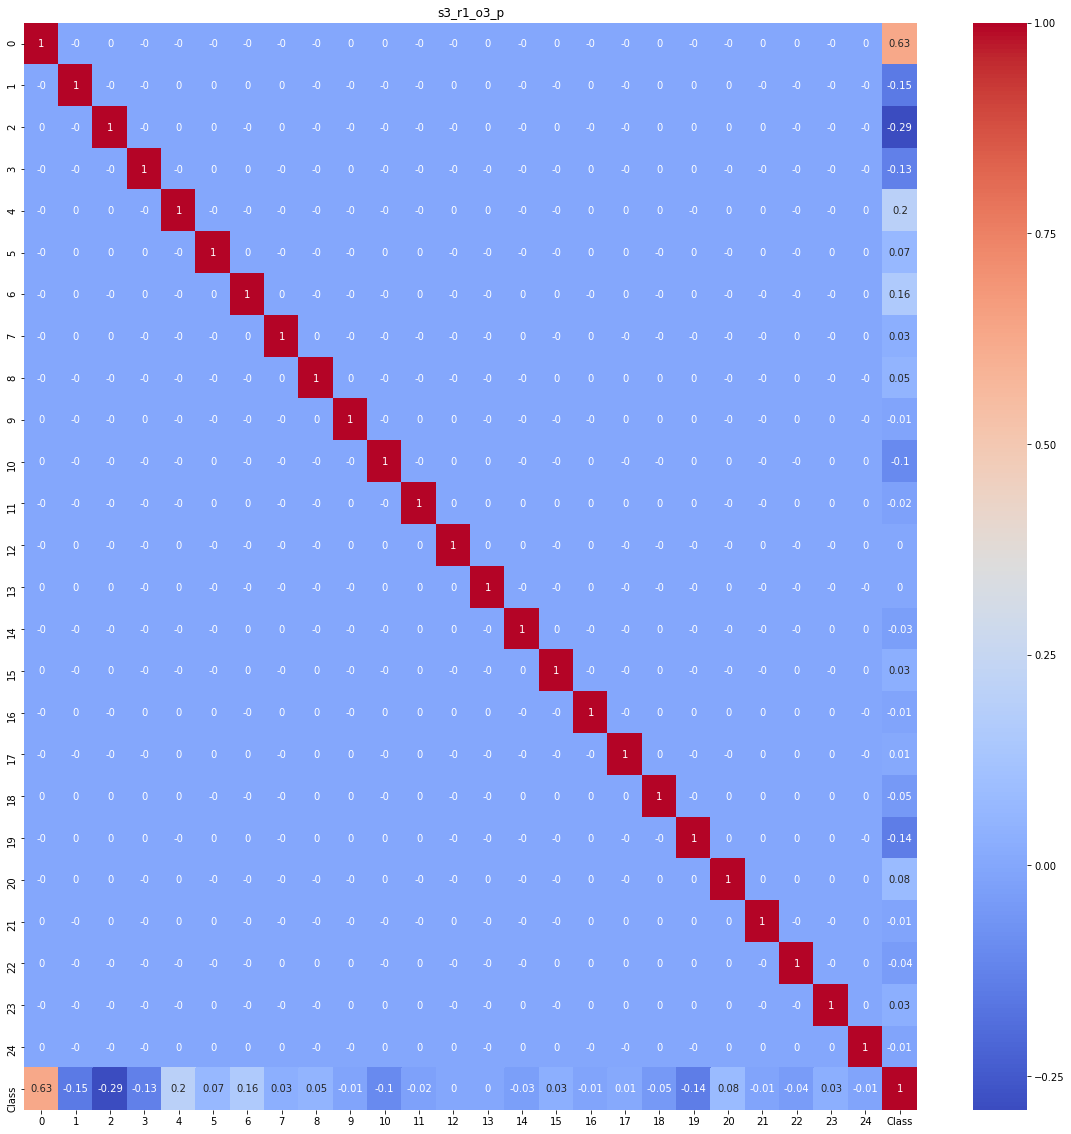

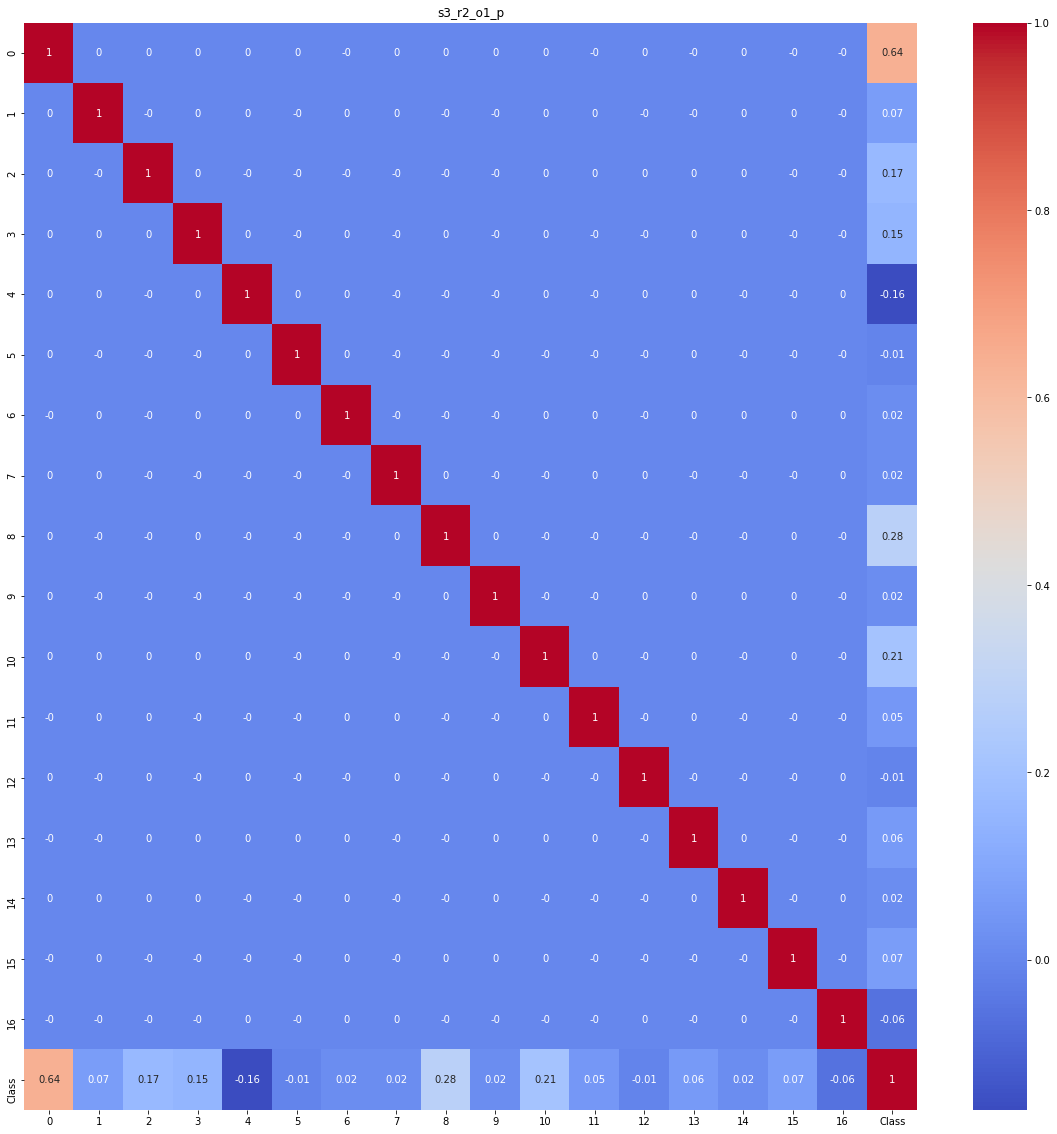

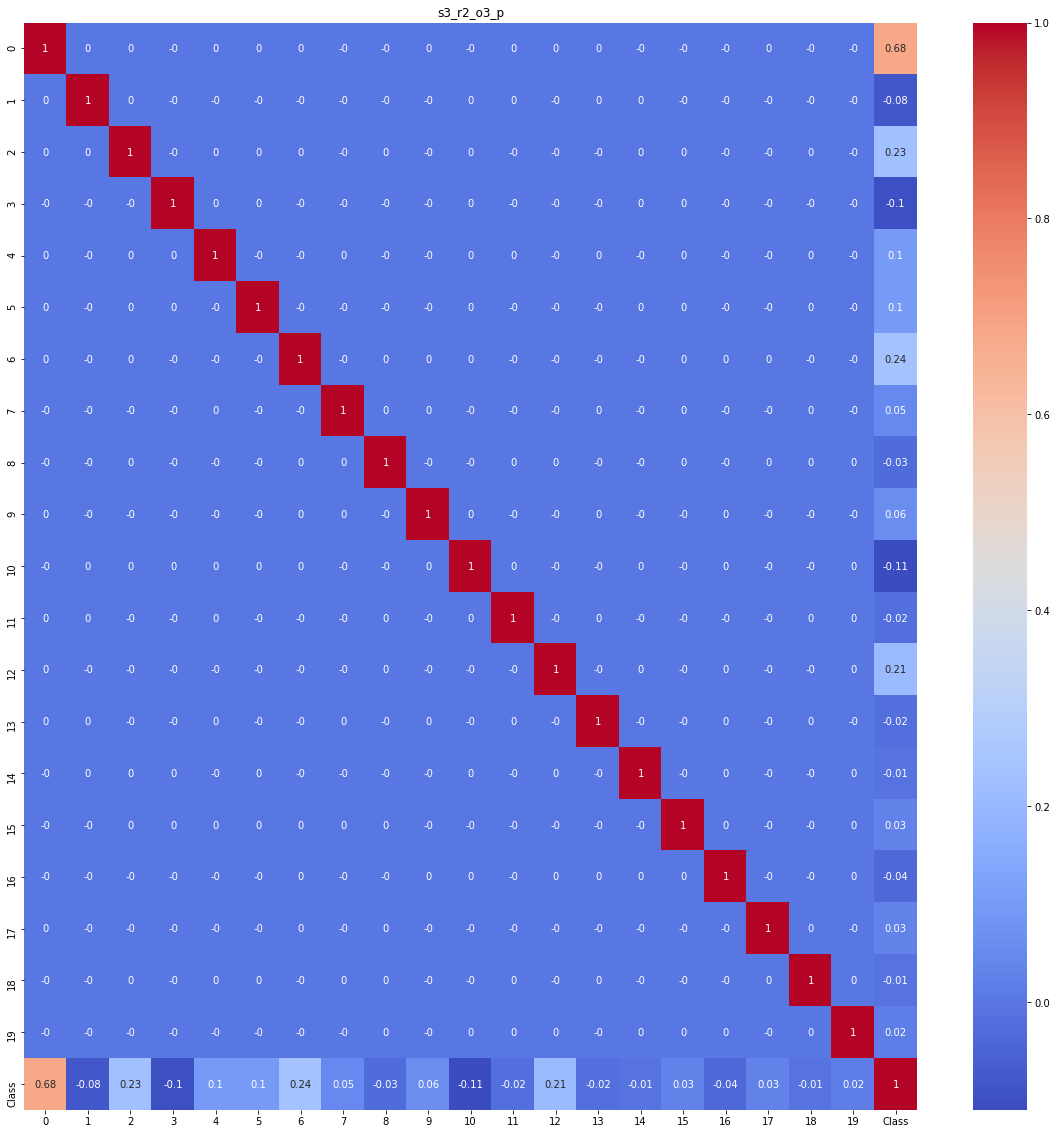

In [108]:
# Draw heat map for each version of the data with PCA
for key in sorted(pc_data.keys()):
    # Function from earlier to draw heat maps
    drawHeatMap(pc_data, key)

PCA removed all multicolinearity from the data and also lowered dimensionality!

## Sources
1) Stack Exchange post: https://datascience.stackexchange.com/questions/32818/train-test-split-of-unbalanced-dataset-classification<br>
2) Top Rated Kaggle Post: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets<br>
3) Scikit Learn Page: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html<br>
4) Microsoft Page on SMOTE: https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/smote<br>
5) GeeksForGeeks Page on NearMiss: https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/ <br>
6) Blog Post on Removing Outliers: 'https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba